In [2]:
import os
import argparse
import pandas as pd
import numpy as np
import xgboost as xgb
from math import ceil
from math import sqrt
from math import acos
from operator import itemgetter
from itertools import product
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import gc
import seaborn as sns
from scipy import stats
from collections import defaultdict
from tqdm import tqdm

In [3]:
def load_data(vector_filename, ion_type):
    # Read file
    if vector_filename.split(".")[-1] == "pkl":
        vectors = pd.read_pickle(vector_filename)
    elif vector_filename.split(".")[-1] == "h5":
        # vectors = pd.read_hdf(vector_filename, key='table', stop=1000)
        vectors = pd.read_hdf(vector_filename, key="table")
    else:
        print("Unsuported feature vector format")
        exit(1)

    # Extract targets for given ion type
    target_names = list(vectors.columns[vectors.columns.str.contains("targets")])
    if not "targets_{}".format(ion_type) in target_names:
        print("Targets for {} could not be found in vector file.".format(ion_type))
        print("Vector file only contains these targets: {}".format(target_names))
        exit(1)

    targets = vectors.pop("targets_{}".format(ion_type))
    target_names.remove("targets_{}".format(ion_type))
    for n in target_names:
        vectors.pop(n)

    # Get psmids
    psmids = vectors.pop("psmid")

    return (vectors, targets, psmids)

In [4]:
def get_params_combinations(params):
    keys, values = zip(*params.items())
    combinations = [dict(zip(keys, v)) for v in product(*values)]
    return(combinations)

In [5]:
def get_best_params(df, params_grid):
    params = {}
    best = df[df['test-rmse-mean'] == df['test-rmse-mean'].min()]
    best_rmse = df['test-rmse-mean'].min()
    for p in params_grid.keys():
        params[p] = best[p].iloc[0]
    # num_boost_round = best['boosting-round'].iloc[0]
    return(params, best_rmse)

In [6]:
def gridsearch(xtrain, params, params_grid):
    cols = ['boosting-round', 'test-rmse-mean', 'test-rmse-std', 'train-rmse-mean', 'train-rmse-std']
    cols.extend(sorted(params_grid.keys()))
    result = pd.DataFrame(columns=cols)

    count = 1
    combinations = get_params_combinations(params_grid)

    for param_overrides in combinations:
        print("Working on combination {}/{}".format(count, len(combinations)))
        count += 1
        params.update(param_overrides)
        tmp = xgb.cv(params, xtrain, nfold=5, num_boost_round=200, early_stopping_rounds=10, verbose_eval=10)
        tmp['boosting-round'] = tmp.index
        for param in param_overrides.keys():
            tmp[param] = param_overrides[param]
        result = result.append(tmp)

    print("Grid search ready!\n")

    return(result)

In [7]:
def ms2pip_pearson(true, pred):
    """
    Return pearson of tic-normalized, log-transformed intensities, 
    the MS2PIP way.
    """
    #tic_norm = lambda x: x / np.sum(x)
    # log_transform = lambda x: np.log2(x + 0.001)
    corr = pearsonr(
        true, 
        pred
    )[0]
    return (corr)

In [8]:
def spectral_angle(true, pred, epsilon=1e-7):
    """
    Return square root normalized spectral angle.
    See https://doi.org/10.1074/mcp.O113.036475
    """
    
    de_log = lambda x: (2**x)-0.001
    l2_normalize = lambda x: x / sqrt(max(sum(x**2), epsilon))
    
    pred_norm = l2_normalize(de_log(pred))
    true_norm = l2_normalize(de_log(true))
    
    spectral_angle = 1 - (2 * acos(np.dot(pred_norm, true_norm)) / np.pi)

    return (spectral_angle)

# New scoring method

In [11]:
class Scorer:
    def __init__(self,psmids):
        self.psmids = psmids
        
    def psm_score(self,targets, predictions):
        tmp = pd.DataFrame(columns=["psmids", "targets", "predictions"])
        tmp["psmids"] = np.array(self.psmids)
        tmp["targets"] = np.array(targets)
        tmp["predictions"] = np.array(predictions)
        tmp2 = tmp.groupby("psmids").agg({'predictions': list, 'targets': list}).reset_index()
        spectral_corr = []
        pearson_corr = []
        for spectra in range(0, len(tmp2["psmids"])):
            spectral_corr.append(spectral_angle(np.array(tmp2.targets.loc[spectra]), np.array(tmp2.predictions.loc[spectra])))
            pearson_corr.append(ms2pip_pearson(np.array(tmp2.targets.loc[spectra]), np.array(tmp2.predictions.loc[spectra])))
        return (pearson_corr, spectral_corr) 

# Hyperparameter optimization y ions

In [4]:
vectors, targets, psmids = load_data("data/immunopeptide_vector.pkl", "Y")

In [5]:
len(psmids.unique())

460191

In [49]:
upeps = psmids.unique()
np.random.shuffle(upeps)
test_psms = upeps[:int(len(upeps) * 0.1)]

train_vectors = vectors[~psmids.isin(test_psms)]
train_targets = targets[~psmids.isin(test_psms)]
train_psmids = psmids[~psmids.isin(test_psms)]

subtrain_vectors = train_vectors[0:10000]
subtrain_targets = train_targets[0:10000]
subtrain_psmids = train_psmids[0:10000]

test_vectors = vectors[psmids.isin(test_psms)]
test_targets = targets[psmids.isin(test_psms)]
test_psmids = psmids[psmids.isin(test_psms)]

In [50]:
xtrain = xgb.DMatrix(train_vectors, label=train_targets)
xsubtrain = xgb.DMatrix(subtrain_vectors, label=subtrain_targets)
xtest = xgb.DMatrix(test_vectors, label=test_targets)
evallist = [(xtrain, 'train'),(xtest, 'test')]

In [11]:
del vectors, targets, psmids, train_vectors, train_targets, train_psmids, test_vectors, subtrain_psmids, subtrain_targets, subtrain_vectors

In [16]:
params = {
    "nthread": 24,
    "objective": "reg:squarederror",
    #"objective": "binary:logistic",
    #"eval_metric": 'mae',
    "eval_metric": 'rmse',
    "verbosity": 1,
    "eta": 0.5,
    "max_depth": 9,
    "grow_policy":"lossguide",
    "max_leaves":100,
    "min_child_weight": 300,
    "gamma": 0.1,
    "subsample": 1,
    "lambda" : 0,
    "colsample_bytree": 1,
    "max_delta_step": 0,
}

In [13]:
params_grid = {
    'eta': [0.01,0.1,0.5],
}

gs = gridsearch(xtrain, params, params_grid)
#gs.to_csv('{}_GridSearchCV.csv'.format(filename))
best_params, best_rmse = get_best_params(gs, params_grid)
params.update(best_params)
print(f"Using best parameters: {best_params} results in rmse = {best_rmse}")

Working on combination 1/3
Working on combination 2/3
Working on combination 3/3
Grid search ready!

Using best parameters: {'eta': 0.5} results in rmse = 0.9469913999999999


In [14]:
params_grid = {
    'max_depth': [7, 8, 9],
    'min_child_weight': [300, 350, 400],
    'gamma': [0, 1],
}

gs = gridsearch(xtrain, params, params_grid)
#gs.to_csv('{}_GridSearchCV.csv'.format(filename))
best_params, best_rmse = get_best_params(gs, params_grid)
params.update(best_params)
print(f"Using best parameters: {best_params} results in rmse = {best_rmse}")


Working on combination 1/18
Working on combination 2/18
Working on combination 3/18
Working on combination 4/18
Working on combination 5/18
Working on combination 6/18
Working on combination 7/18
Working on combination 8/18
Working on combination 9/18
Working on combination 10/18
Working on combination 11/18
Working on combination 12/18
Working on combination 13/18
Working on combination 14/18
Working on combination 15/18
Working on combination 16/18
Working on combination 17/18
Working on combination 18/18
Grid search ready!

Using best parameters: {'max_depth': 9, 'min_child_weight': 300, 'gamma': 0} results in rmse = 0.9466764


In [16]:
params

{'nthread': 24,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'verbosity': 1,
 'eta': 0.5,
 'max_depth': 9,
 'grow_policy': 'lossguide',
 'max_leaves': 100,
 'min_child_weight': 300,
 'gamma': 0,
 'subsample': 1,
 'lambda': 0,
 'colsample_bytree': 0.6,
 'max_delta_step': 0}

In [17]:
params_grid = {
    'max_depth': [9,10],
    'min_child_weight': [275, 300, 325]
}

gs = gridsearch(xtrain, params, params_grid)
#gs.to_csv('{}_GridSearchCV.csv'.format(filename))
best_params, best_rmse = get_best_params(gs, params_grid)
params.update(best_params)
print(f"Using best parameters: {best_params} results in rmse = {best_rmse}")

Working on combination 1/6
Working on combination 2/6
Working on combination 3/6
Working on combination 4/6
Working on combination 5/6
Working on combination 6/6
Grid search ready!

Using best parameters: {'max_depth': 10, 'min_child_weight': 300} results in rmse = 0.9393974


In [18]:
params_grid = {
    'lambda': [0, 1],
    'colsample_bytree': [0.3, 0.6, 1],
}

gs = gridsearch(xtrain, params, params_grid)
#gs.to_csv('{}_GridSearchCV.csv'.format(filename))
best_params, best_rmse = get_best_params(gs, params_grid)
params.update(best_params)
print(f"Using best parameters: {best_params} results in rmse = {best_rmse}")

Working on combination 1/6
Working on combination 2/6
Working on combination 3/6
Working on combination 4/6
Working on combination 5/6
Working on combination 6/6
Grid search ready!

Using best parameters: {'lambda': 1, 'colsample_bytree': 0.6} results in rmse = 0.9388514000000001


In [667]:
params

{'nthread': 24,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'verbosity': 1,
 'eta': 0.5,
 'max_depth': 10,
 'grow_policy': 'lossguide',
 'max_leaves': 100,
 'min_child_weight': 300,
 'gamma': 0,
 'subsample': 1,
 'lambda': 1,
 'colsample_bytree': 0.6,
 'max_delta_step': 0}

In [21]:
best = gs[gs['test-rmse-mean'] == gs['test-rmse-mean'].min()]

In [22]:
best

,boosting-round,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std,colsample_bytree,lambda
199,199,0.938851,0.002331,0.873698,0.001874,0.6,1


In [ ]:
params

In [668]:
bst = xgb.train(params, xtrain, 300, evallist, maximize=False, early_stopping_rounds=10)


[0]	test-rmse:4.56113	train-rmse:4.55658
[1]	test-rmse:2.54116	train-rmse:2.53759
[2]	test-rmse:1.66212	train-rmse:1.65962
[3]	test-rmse:1.29485	train-rmse:1.29302
[4]	test-rmse:1.17543	train-rmse:1.17405
[5]	test-rmse:1.12738	train-rmse:1.12564
[6]	test-rmse:1.10181	train-rmse:1.09970
[7]	test-rmse:1.08751	train-rmse:1.08502
[8]	test-rmse:1.08061	train-rmse:1.07789
[9]	test-rmse:1.06750	train-rmse:1.06439
[10]	test-rmse:1.06089	train-rmse:1.05754
[11]	test-rmse:1.05638	train-rmse:1.05264
[12]	test-rmse:1.05192	train-rmse:1.04762
[13]	test-rmse:1.04830	train-rmse:1.04352
[14]	test-rmse:1.04359	train-rmse:1.03812
[15]	test-rmse:1.03670	train-rmse:1.03081
[16]	test-rmse:1.03099	train-rmse:1.02466
[17]	test-rmse:1.02841	train-rmse:1.02161
[18]	test-rmse:1.02606	train-rmse:1.01890
[19]	test-rmse:1.02276	train-rmse:1.01518
[20]	test-rmse:1.02128	train-rmse:1.01307
[21]	test-rmse:1.01910	train-rmse:1.01019
[22]	test-rmse:1.01673	train-rmse:1.00761
[23]	test-rmse:1.01401	train-rmse:1.00452
[2

[194]	test-rmse:0.93875	train-rmse:0.88143
[195]	test-rmse:0.93877	train-rmse:0.88135
[196]	test-rmse:0.93872	train-rmse:0.88115
[197]	test-rmse:0.93854	train-rmse:0.88067
[198]	test-rmse:0.93817	train-rmse:0.88009
[199]	test-rmse:0.93793	train-rmse:0.87961
[200]	test-rmse:0.93786	train-rmse:0.87925
[201]	test-rmse:0.93786	train-rmse:0.87898
[202]	test-rmse:0.93778	train-rmse:0.87864
[203]	test-rmse:0.93767	train-rmse:0.87828
[204]	test-rmse:0.93758	train-rmse:0.87802
[205]	test-rmse:0.93755	train-rmse:0.87786
[206]	test-rmse:0.93742	train-rmse:0.87745
[207]	test-rmse:0.93730	train-rmse:0.87693
[208]	test-rmse:0.93725	train-rmse:0.87664
[209]	test-rmse:0.93719	train-rmse:0.87638
[210]	test-rmse:0.93717	train-rmse:0.87614
[211]	test-rmse:0.93715	train-rmse:0.87579
[212]	test-rmse:0.93712	train-rmse:0.87560
[213]	test-rmse:0.93685	train-rmse:0.87511
[214]	test-rmse:0.93688	train-rmse:0.87485
[215]	test-rmse:0.93679	train-rmse:0.87441
[216]	test-rmse:0.93675	train-rmse:0.87409
[217]	test-

In [680]:
#bst.save_model("non_tryptic_HCDy.xgboost")

# Model performance on xtest

In [197]:
bst = xgb.Booster({'nthread': 24})  # init model
bst.load_model("Models/joint_HCDy.xgboost")

In [52]:
predictions = bst.predict(xtest)
predictions

array([-6.3507347, -6.639639 , -7.841158 , ..., -9.0703335, -9.098165 ,
       -7.6705446], dtype=float32)

In [53]:
data = pd.DataFrame()
data["spec_id"] = test_psmids
data["test_targets"] = np.array(test_targets)
data["predictions"] = predictions

In [54]:
data.head()

,spec_id,test_targets,predictions
108,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-6.782201,-6.350735
109,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-6.541206,-6.639639
110,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-7.689009,-7.841158
111,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-9.228428,-9.117106
112,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-6.569669,-7.209731


In [57]:
performance = Scorer(test_psmids)
pear_corr, spec_corr  = performance.psm_score(test_targets, predictions)


/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


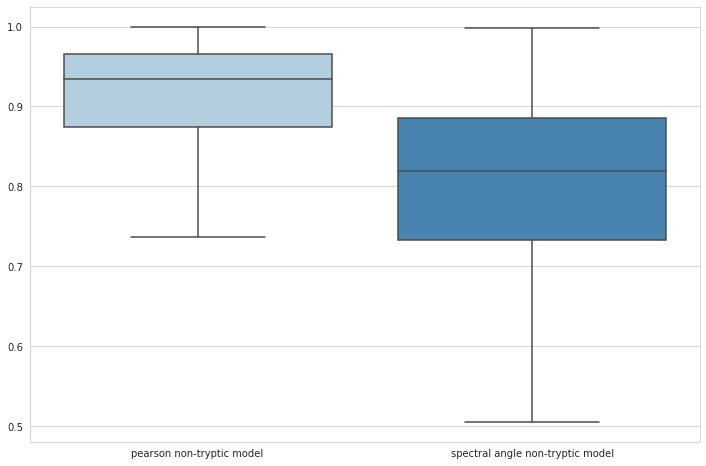

In [60]:
plt.figure(figsize=(12, 8))
model_perf = pd.DataFrame(columns=["pearson non-tryptic model", "spectral angle non-tryptic model"])
model_perf["pearson non-tryptic model"] = pear_corr
model_perf["spectral angle non-tryptic model"] = spec_corr
sns.set_style("whitegrid")
sns.boxplot(data = model_perf, palette="Blues",showfliers = False)

plt.show()

# Comparison current tryptic ms2pip model on non-tryptic test

In [62]:
t_ms2pip_pred = pd.read_csv("data/trainpeprec_HCD_pred_and_emp.csv")
t_ms2pip_pred = t_ms2pip_pred[t_ms2pip_pred["ion"] == "Y"]
boolean = t_ms2pip_pred.spec_id.isin(list(test_psmids.unique()))
t_ms2pip_pred = t_ms2pip_pred[boolean]
t_ms2pip_pred = t_ms2pip_pred.drop([ 'charge','ion', 'ionnumber',"mz"], axis=1)

In [63]:
t_ms2pip_pred.head()

,spec_id,prediction,target
948,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-12.214846,-9.965784
949,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-4.785283,-6.477926
950,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-6.767243,-5.030716
951,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-8.735328,-7.015738
952,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-8.208818,-8.329968


In [65]:
performance= Scorer(t_ms2pip_pred.spec_id)
pear_corr_t, spec_corr_t = performance.psm_score(t_ms2pip_pred.target, t_ms2pip_pred.prediction)

/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


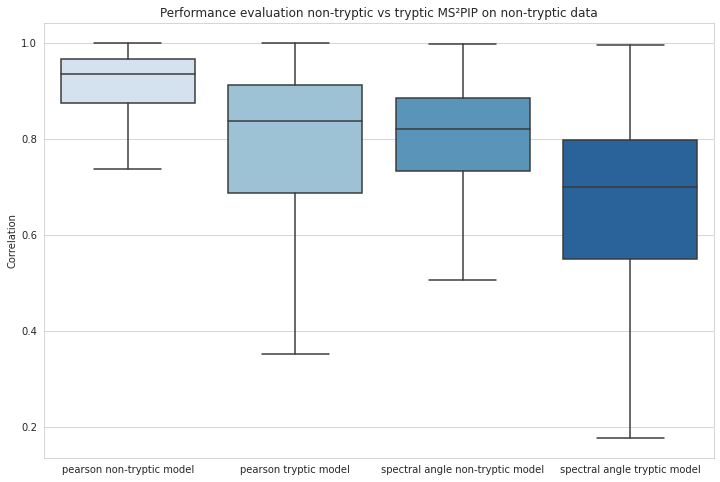

In [66]:
model_perf["pearson tryptic model"] = pear_corr_t
model_perf["spectral angle tryptic model"] = spec_corr_t

plt.figure(figsize=(12, 8))
sns.boxplot(data = model_perf, palette="Blues",showfliers = False, order=["pearson non-tryptic model", "pearson tryptic model", "spectral angle non-tryptic model", "spectral angle tryptic model"])
plt.title("Performance evaluation non-tryptic vs tryptic MS²PIP on non-tryptic data")
plt.ylabel('Correlation')
sns.set_style("whitegrid")
plt.show()

In [143]:
model_perf

,pearson non-tryptic model,spectral angle non-tryptic model,pearson tryptic model,spectral angle tryptic model
0,0.971214,9.050382e-01,0.835509,5.717573e-01
1,0.936025,7.640897e-01,0.925882,8.527339e-01
2,0.962011,9.366363e-01,0.817359,8.301511e-01
3,0.996853,9.875959e-01,0.974437,6.957689e-01
4,0.962908,6.691412e-01,0.978776,7.661609e-01
...,...,...,...,...
46014,0.914951,9.066097e-01,0.882987,9.394794e-01
46015,0.903358,7.282253e-01,0.617820,7.028720e-01
46016,0.981421,8.941087e-01,0.778141,6.323292e-01
46017,0.175578,8.639304e-02,0.313455,9.160248e-02


# Learning curve model

In [471]:
params

{'nthread': 24,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'verbosity': 1,
 'eta': 0.5,
 'max_depth': 10,
 'grow_policy': 'lossguide',
 'max_leaves': 100,
 'min_child_weight': 300,
 'gamma': 0,
 'subsample': 1,
 'lambda': 1,
 'colsample_bytree': 0.6,
 'max_delta_step': 0}

In [472]:
upeps = psmids.unique()
np.random.shuffle(upeps)
test_psms = upeps[:int(len(upeps) * 0.1)]

train_vectors = vectors[~psmids.isin(test_psms)]
train_targets = targets[~psmids.isin(test_psms)]
train_psmids = psmids[~psmids.isin(test_psms)]

test_vectors = vectors[psmids.isin(test_psms)]
test_targets = targets[psmids.isin(test_psms)]
test_psmids = psmids[psmids.isin(test_psms)]

In [473]:
xtest = xgb.DMatrix(test_vectors, label=test_targets)

In [477]:
train_ratios = [0.001,0.01,0.1,0.2,0.4,0.6,0.8,1]
train_upeps = train_psmids.unique()
np.random.shuffle(train_upeps)
learning_pred = dict({"test_psmids": test_psmids,"test_targets": test_targets})

for ratio in train_ratios:
    train_psm = train_upeps[:int(len(train_upeps) * ratio)]
    
    subset_train_vectors = train_vectors[train_psmids.isin(train_psm)]
    subset_train_targets = train_targets[train_psmids.isin(train_psm)]
    subset_train_psmids = train_psmids[train_psmids.isin(train_psm)]
    
    print(f"training on {len(subset_train_psmids.unique())} upeps")
    print(f"training vector: {len(subset_train_vectors)}")
    xtrain = xgb.DMatrix(subset_train_vectors, label=subset_train_targets)
    
    bst = xgb.train(params, xtrain, 300, maximize=False)
    model = str(len(subset_train_psmids.unique()))
    predictions = bst.predict(xtest)
    learning_pred[model] = predictions
    
df = pd.DataFrame.from_dict(learning_pred)
df.to_csv("Learning_curve_predictions.csv",sep=",")

training on 414 upeps
training vector: 4863
training on 4141 upeps
training vector: 49015
training on 41417 upeps
training vector: 492569
training on 82834 upeps
training vector: 983422
training on 165668 upeps
training vector: 1966670
training on 248503 upeps
training vector: 2950638
training on 331337 upeps
training vector: 3933145
training on 414172 upeps
training vector: 4915326


In [9]:
learning_curve = pd.read_csv("data/Learning_curve_predictions.csv", index_col=0)
learning_curve.head()

,test_psmids,test_targets,414,4141,41417,82834,165668,248503,331337,414172
8,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-9.965784,-10.289854,-8.781439,-8.671447,-9.631455,-9.507187,-9.957754,-10.056781,-10.322131
9,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-8.548015,-8.814545,-8.575631,-8.618166,-8.897274,-7.881528,-8.768586,-8.933926,-9.654906
10,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-7.706262,-7.979366,-9.367040,-7.718490,-8.687053,-7.630899,-8.057115,-7.122783,-8.709035
11,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-8.371382,-6.707862,-6.642095,-6.924498,-8.209811,-8.469976,-8.598723,-8.545157,-8.124200
12,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-9.965784,-6.605071,-8.698034,-9.113148,-9.249889,-8.335603,-8.793955,-9.171150,-8.898093


In [12]:
pearson_correlations = pd.DataFrame(columns=learning_curve.columns.drop(["test_psmids", "test_targets"]))
pearson = Scorer(learning_curve.test_psmids)
for training_pep in pearson_correlations.columns:
    pearson_correlations[training_pep], _ = pearson.psm_score(learning_curve["test_targets"], learning_curve[training_pep])
    

/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [13]:
gradient_colors = ["#1AA3FF", "#1696F1" , "#138AE3" , "#0F7DD5" , "#0B70C8" , "#0763BA" ,"#0457AC" , "#004A9E"]
gradient_blues = sns.color_palette(gradient_colors)


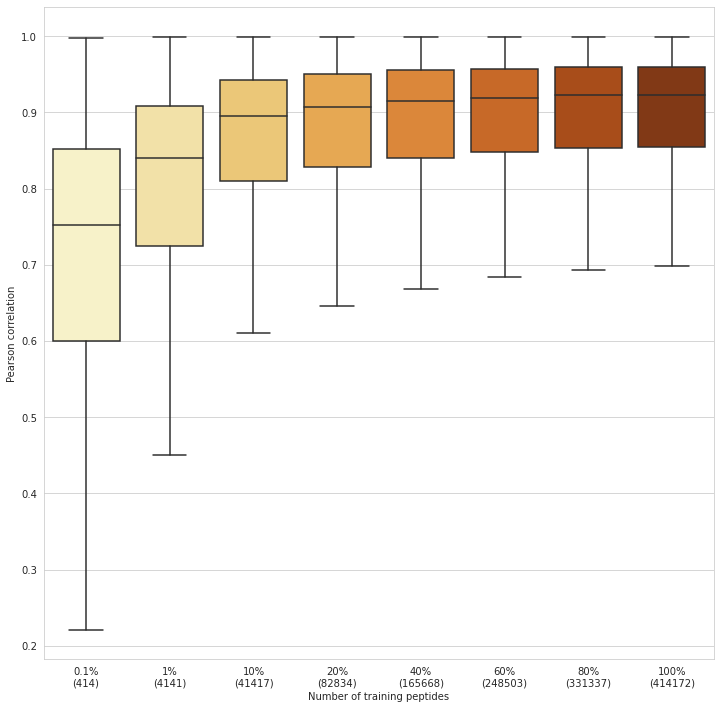

In [22]:
train_ratios = ["0.1%\n(414)","1%\n(4141)","10%\n(41417)","20%\n(82834)","40%\n(165668)","60%\n(248503)","80%\n(331337)","100%\n(414172)"]
plt.figure(figsize=(12, 12))
ax = sns.boxplot(data = pearson_correlations, palette="YlOrBr" ,showfliers = False)
sns.set_style("whitegrid")
ax.set_xticklabels(train_ratios)
plt.ylabel('Pearson correlation')
plt.xlabel('Number of training peptides')
sns.set_style("whitegrid")
plt.show()

In [17]:
spectral_correlations = pd.DataFrame(columns=learning_curve.columns.drop(["test_psmids", "test_targets"]))
spectral = Scorer(learning_curve.test_psmids)
for training_pep in pearson_correlations.columns:
    _, spectral_correlations[training_pep] = spectral.psm_score(learning_curve["test_targets"], learning_curve[training_pep])
    

/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


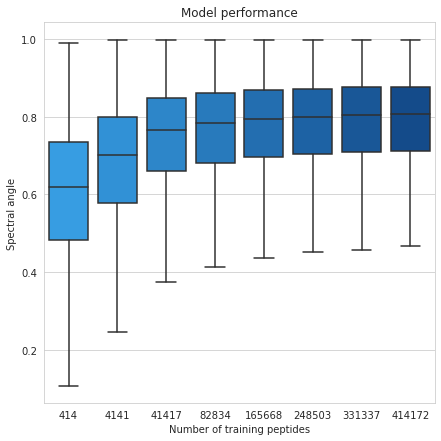

In [18]:
plt.figure(figsize=(7, 7))
sns.boxplot(data = spectral_correlations, palette=gradient_blues,showfliers = False)
ax.set_xticklabels(train_ratios)
plt.ylabel('Spectral angle')
plt.xlabel('Number of training peptides')
sns.set_style("whitegrid")
plt.show()

In [23]:
median_corr = pd.DataFrame(columns=["Median pearson correlation", "Median spectral angle"])
median_corr["Median pearson correlation"] = pearson_correlations.median()
median_corr["Median spectral angle"] = spectral_correlations.median()
median_corr = median_corr.reset_index().rename(columns={"index": "Unique peptides"})

In [25]:
median_corr

,Unique peptides,Median pearson correlation,Median spectral angle
0,414,0.752869,0.618760
1,4141,0.840797,0.700632
2,41417,0.895673,0.765686
3,82834,0.907525,0.783644
4,165668,0.915170,0.794367
5,248503,0.919458,0.800081
6,331337,0.922533,0.805003
7,414172,0.923351,0.806745


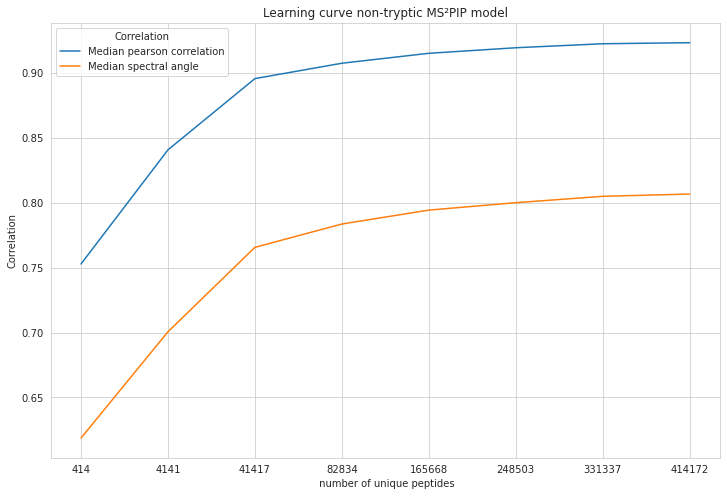

In [26]:
plt.figure(figsize=(12,8))
sns.lineplot(x="Unique peptides", y="Value", hue="Correlation",data=pd.melt(median_corr,"Unique peptides", var_name='Correlation',value_name='Value'))
plt.title("Learning curve non-tryptic MS²PIP model")
plt.ylabel('Correlation')
plt.xlabel(' number of unique peptides')
sns.set_style("whitegrid")
plt.show()

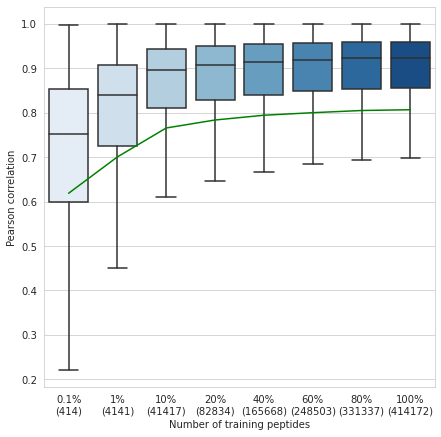

In [33]:
fig, ax = plt.subplots(figsize=(7, 7))
train_ratios = ["0.1%\n(414)","1%\n(4141)","10%\n(41417)","20%\n(82834)","40%\n(165668)","60%\n(248503)","80%\n(331337)","100%\n(414172)"]
sns.boxplot(ax=ax, data = pearson_correlations, palette="Blues",showfliers = False)
sns.lineplot(ax=ax, x="Unique peptides", y="Median spectral angle",data=median_corr, color="green")
ax.set_xticklabels(train_ratios)
plt.ylabel('Pearson correlation')
plt.xlabel('Number of training peptides')
sns.set_style("whitegrid")
plt.show()

# Comparison with ms2pip on tryptic test data

In [68]:
t_ms2pip_tt_pred = pd.read_csv("data/HCD_PXD008034_Ecoli_HCD_pred_and_emp.csv")
t_ms2pip_tt_pred = t_ms2pip_tt_pred[t_ms2pip_tt_pred["ion"] == "Y"]
t_ms2pip_tt_pred = t_ms2pip_tt_pred.drop([ 'charge','ion', 'ionnumber',"mz","rt"], axis=1)

In [69]:
t_ms2pip_tt_pred.head()

,spec_id,prediction,target
8,34267,-5.503998,-5.703898
9,34267,-9.122413,-9.965784
10,34267,-6.230111,-7.815557
11,34267,-8.943034,-8.136665
12,34267,-6.246614,-6.964776


In [71]:
performance = Scorer(t_ms2pip_tt_pred.spec_id)
pear_corr_tryptic_test, spec_corr_tryptic_test = performance.psm_score(t_ms2pip_tt_pred.target, t_ms2pip_tt_pred.prediction)

/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [72]:
model_perf_tryptic_test = pd.DataFrame()
model_perf_tryptic_test["pearson tryptic model"] = pear_corr_tryptic_test
model_perf_tryptic_test["spectral angle tryptic model"] = spec_corr_tryptic_test

In [75]:
tt_vectors, tt_targets, tt_psmids = load_data("data/tryptic_test_vector.pkl", "Y")

In [76]:
tryptic_test = xgb.DMatrix(tt_vectors, label=tt_targets)

In [77]:
predictions = bst.predict(tryptic_test)
predictions

array([-8.002462 , -4.2398586, -5.686137 , ..., -8.426824 , -8.377093 ,
       -9.839242 ], dtype=float32)

In [78]:
data = pd.DataFrame()
data["spec_id"] = tt_psmids
data["test_targets"] = np.array(tt_targets)
data["predictions"] = predictions

In [79]:
performance = Scorer(tt_psmids)
pear_corr_tryptic_test, spec_corr_tryptic_test = performance.psm_score(tt_targets, predictions)


/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [80]:
model_perf_tryptic_test["pearson non-tryptic model"] = pear_corr_tryptic_test
model_perf_tryptic_test["spectral angle non-tryptic model"] = spec_corr_tryptic_test

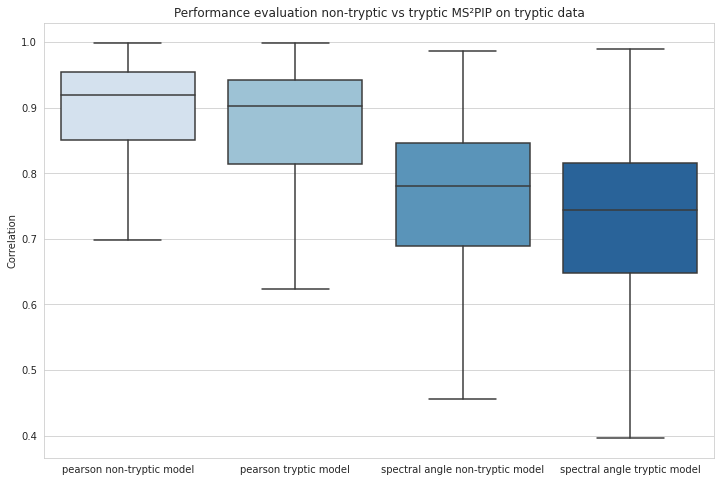

In [81]:
plt.figure(figsize=(12, 8))
sns.boxplot(data = model_perf_tryptic_test, palette="Blues",showfliers = False , order=["pearson non-tryptic model", "pearson tryptic model", "spectral angle non-tryptic model", "spectral angle tryptic model"])
plt.title("Performance evaluation non-tryptic vs tryptic MS²PIP on tryptic data")
plt.ylabel('Correlation')
sns.set_style("whitegrid")
plt.show()

# Summary tryptic vs non-tryptic MS²PIP

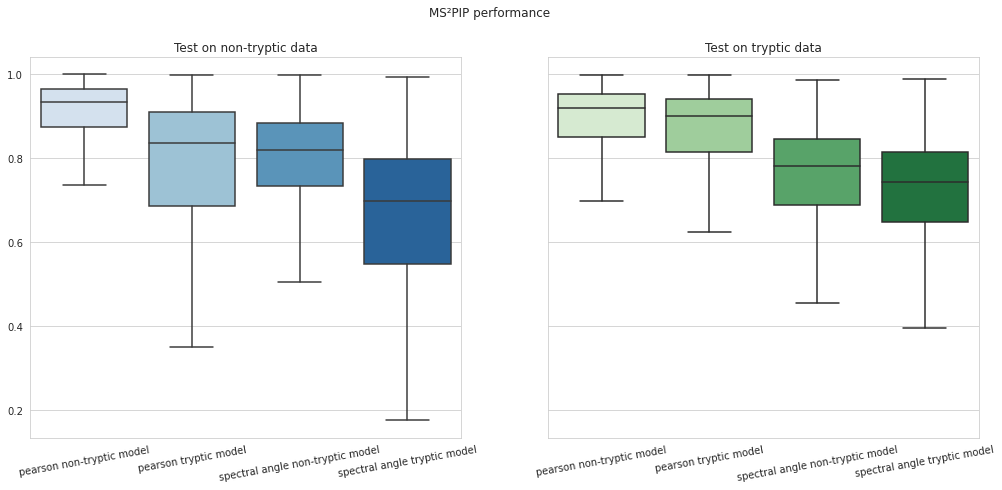

In [82]:
fig, axes = plt.subplots(1,2, figsize=(17,7), sharey=True)
fig.suptitle("MS²PIP performance")

sns.boxplot(ax=axes[0], data = model_perf, palette="Blues",showfliers = False, order=["pearson non-tryptic model", "pearson tryptic model", "spectral angle non-tryptic model", "spectral angle tryptic model"])
axes[0].set_title("Test on non-tryptic data")
plt.setp(axes[0].get_xticklabels(), rotation=10, horizontalalignment='center')
sns.boxplot(ax=axes[1], data = model_perf_tryptic_test, palette="Greens",showfliers = False , order=["pearson non-tryptic model", "pearson tryptic model", "spectral angle non-tryptic model", "spectral angle tryptic model"])
axes[1].set_title("Test on tryptic data")
plt.setp(axes[1].get_xticklabels(), rotation=10, horizontalalignment='center')
plt.show()

In [188]:
tryptic_vectors, tryptic_targets, tryptic_psmids = load_data("data/tryptic_test_vector.pkl", "Y")
non_tryptic_vectors, non_tryptic_targets, non_tryptic_psmids = load_data("data/non_tryptic_test_vector.pkl", "Y")

In [189]:
tryptic_test = xgb.DMatrix(tryptic_vectors, label=tryptic_targets)
non_tryptic_test = xgb.DMatrix(non_tryptic_vectors, label=non_tryptic_targets)

In [190]:
predictions_tryptic = bst.predict(tryptic_test)
predictions_non_tryptic = bst.predict(non_tryptic_test)

In [191]:
ms2pip_pred_tryptic = pd.read_csv("data/HCD_PXD008034_Ecoli_HCD_pred_and_emp.csv")
ms2pip_pred_tryptic = ms2pip_pred_tryptic[ms2pip_pred_tryptic["ion"] == "Y"]
ms2pip_pred_tryptic = ms2pip_pred_tryptic.drop([ 'charge','ion', 'ionnumber',"mz", "rt"], axis=1)

ms2pip_pred_non_tryptic = pd.read_csv("data/spec_lib_PXD005231_HCD_pred_and_emp.csv")
ms2pip_pred_non_tryptic = ms2pip_pred_non_tryptic[ms2pip_pred_non_tryptic["ion"] == "Y"]
ms2pip_pred_non_tryptic = ms2pip_pred_non_tryptic.drop([ 'charge','ion', 'ionnumber',"mz"], axis=1)

In [192]:
tryptic_test_N = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
tryptic_new_model = Scorer(tryptic_psmids)
tryptic_test_N["pearson correlation"], tryptic_test_N["spectral angle"] = tryptic_new_model.psm_score(tryptic_targets,predictions_tryptic)
tryptic_test_N["type"] = "tryptic"

non_tryptic_test_N = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
non_tryptic_new_model = Scorer(non_tryptic_psmids)
non_tryptic_test_N["pearson correlation"], non_tryptic_test_N["spectral angle"] = non_tryptic_new_model.psm_score(non_tryptic_targets,predictions_non_tryptic)
non_tryptic_test_N["type"] = "non-tryptic"

New_model_perf = pd.concat([tryptic_test_N, non_tryptic_test_N])
New_model_perf["Model"] = "new model"

/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [193]:
tryptic_test_C = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
tryptic_current_model = Scorer(ms2pip_pred_tryptic["spec_id"])
tryptic_test_C["pearson correlation"], tryptic_test_C["spectral angle"] = tryptic_current_model.psm_score(ms2pip_pred_tryptic["target"],ms2pip_pred_tryptic["prediction"])
tryptic_test_C["type"] = "tryptic"

non_tryptic_test_C = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
non_tryptic_current_model = Scorer(ms2pip_pred_non_tryptic["spec_id"])
non_tryptic_test_C["pearson correlation"], non_tryptic_test_C["spectral angle"] = non_tryptic_current_model.psm_score(ms2pip_pred_non_tryptic["target"],ms2pip_pred_non_tryptic["prediction"])
non_tryptic_test_C["type"] = "non-tryptic"

Current_model_perf = pd.concat([tryptic_test_C, non_tryptic_test_C])
Current_model_perf["Model"] = "current model"

In [194]:
model_comparison = pd.concat([Current_model_perf, New_model_perf])

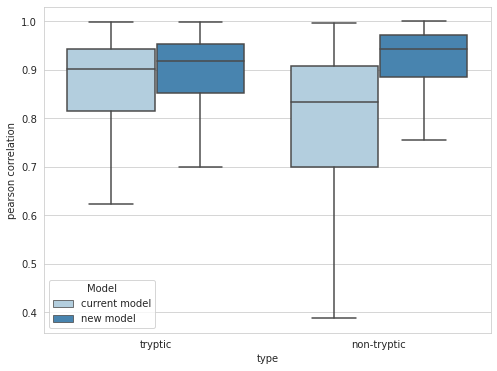

In [195]:
plt.figure(figsize=(8, 6))
sns.boxplot(data = model_comparison, x="type", y="pearson correlation",hue="Model", palette="Blues", showfliers = False)
plt.show()

## Median correlations

In [211]:
print(f'PC tryptic current model: {Current_model_perf["pearson correlation"][Current_model_perf.type=="tryptic"].median()}')
print(f'SA tryptic current model: {(Current_model_perf["spectral angle"][Current_model_perf.type == "tryptic"].median())}')
print(f'PC non-tryptic current model: {(Current_model_perf["pearson correlation"][Current_model_perf.type == "non-tryptic"].median())}')
print(f'SA non-tryptic current model: {(Current_model_perf["spectral angle"][Current_model_perf.type == "non-tryptic"].median())}')

print(f'PC tryptic new model: {(New_model_perf["pearson correlation"][New_model_perf.type == "tryptic"].median())}')
print(f'SA tryptic new model: {(New_model_perf["spectral angle"][New_model_perf.type == "tryptic"].median())}')
print(f'PC non-tryptic new model: {(New_model_perf["pearson correlation"][New_model_perf.type == "non-tryptic"].median())}')
print(f'SA non-tryptic new model: {(New_model_perf["spectral angle"][New_model_perf.type == "non-tryptic"].median())}')

PC tryptic current model: 0.9019213834602811
SA tryptic current model: 0.743854469219152
PC non-tryptic current model: 0.8325743398930274
SA non-tryptic current model: 0.7072390396637754
PC tryptic new model: 0.9188768513734527
SA tryptic new model: 0.7813193276141517
PC non-tryptic new model: 0.9428776079839848
SA non-tryptic new model: 0.840635030324531


# Beyasian optimization with hyperopt


In [253]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe , space_eval
import time

In [23]:
space= {
    'eta': hp.loguniform('eta', np.log(0.01), np.log(1)),
    'max_depth': hp.quniform('max_depth', 3, 18, 1),
    'max_leaves': hp.quniform('max_leaves', 5, 500, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'gamma' : hp.uniform ('gamma', 0.0,1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 500, 1),
    'subsample': hp.quniform('subsample', 0.5, 1 ,0.1),
    'reg_alpha': hp.quniform('reg_alpha', 0, 5 ,0.1)
}

In [24]:
def objective(space):
    params = {
    "nthread": 64,
    "objective": "reg:squarederror",
    "eval_metric": 'rmse',
    "eta": space["eta"],
    "max_depth": int(space['max_depth']),
    "grow_policy":"lossguide",
    "max_leaves":int(space["max_leaves"]),
    "min_child_weight": int(space["min_child_weight"]),
    "gamma": space['gamma'],
    "reg_lambda" : space['reg_lambda'],
    "colsample_bytree": space['colsample_bytree'],
    "subsample" : space["subsample"],
    "reg_alpha" : space["reg_alpha"]
    }
    print(params)
    tmp = xgb.cv(params, xtrain, nfold=4, num_boost_round=400, early_stopping_rounds=10, verbose_eval=True)
    rmse = tmp['test-rmse-mean'].min()

    print ("rmse:", rmse)
    return {'loss': rmse, 'status': STATUS_OK, "params": params}

In [25]:
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 25,
                        trials = trials)


best_hyperparams

{'nthread': 64, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.19139564754226965, 'max_depth': 4, 'grow_policy': 'lossguide', 'max_leaves': 37, 'min_child_weight': 51, 'gamma': 0.5747440777049491, 'reg_lambda': 0.9195442965668339, 'colsample_bytree': 0.6739423572042653, 'subsample': 0.9, 'reg_alpha': 0.9}
[0]	train-rmse:7.18291+0.00037	test-rmse:7.18288+0.00108

[1]	train-rmse:5.88579+0.00079	test-rmse:5.88567+0.00096

[2]	train-rmse:4.85175+0.00177	test-rmse:4.85158+0.00213

[3]	train-rmse:4.03132+0.00198	test-rmse:4.03129+0.00211

[4]	train-rmse:3.38526+0.00097	test-rmse:3.38527+0.00123

[5]	train-rmse:2.88340+0.00149	test-rmse:2.88335+0.00121

[6]	train-rmse:2.49612+0.00213	test-rmse:2.49610+0.00160

[7]	train-rmse:2.20427+0.00140	test-rmse:2.20420+0.00092

[8]	train-rmse:1.98714+0.00281	test-rmse:1.98717+0.00204

[9]	train-rmse:1.82708+0.00259	test-rmse:1.82716+0.00211

[10]	train-rmse:1.71035+0.00441	test-rmse:1.71038+0.00371

[11]	train-rmse:1.62611+0.00493	test

[133]	train-rmse:1.17132+0.00314	test-rmse:1.17212+0.00271

[134]	train-rmse:1.17071+0.00324	test-rmse:1.17152+0.00278

[135]	train-rmse:1.17002+0.00324	test-rmse:1.17084+0.00276

[136]	train-rmse:1.16913+0.00366	test-rmse:1.16997+0.00317

[137]	train-rmse:1.16835+0.00330	test-rmse:1.16918+0.00287

[138]	train-rmse:1.16790+0.00326	test-rmse:1.16873+0.00282

[139]	train-rmse:1.16729+0.00326	test-rmse:1.16812+0.00282

[140]	train-rmse:1.16641+0.00303	test-rmse:1.16722+0.00259

[141]	train-rmse:1.16606+0.00300	test-rmse:1.16687+0.00258

[142]	train-rmse:1.16544+0.00283	test-rmse:1.16626+0.00242

[143]	train-rmse:1.16477+0.00270	test-rmse:1.16560+0.00226

[144]	train-rmse:1.16445+0.00276	test-rmse:1.16529+0.00231

[145]	train-rmse:1.16381+0.00308	test-rmse:1.16467+0.00260

[146]	train-rmse:1.16331+0.00300	test-rmse:1.16416+0.00250

[147]	train-rmse:1.16282+0.00292	test-rmse:1.16369+0.00241

[148]	train-rmse:1.16211+0.00254	test-rmse:1.16298+0.00205

[149]	train-rmse:1.16145+0.00245	test-rm

[0]	train-rmse:8.37129+0.00038	test-rmse:8.37092+0.00109                    

[1]	train-rmse:7.96128+0.00038	test-rmse:7.96153+0.00104                    

[2]	train-rmse:7.57274+0.00032	test-rmse:7.57312+0.00101                    

[3]	train-rmse:7.20389+0.00045	test-rmse:7.20429+0.00083                    

[4]	train-rmse:6.85396+0.00045	test-rmse:6.85420+0.00078                    

[5]	train-rmse:6.52155+0.00041	test-rmse:6.52190+0.00077                    

[6]	train-rmse:6.20591+0.00035	test-rmse:6.20666+0.00081                    

[7]	train-rmse:5.90677+0.00038	test-rmse:5.90743+0.00074                    

[8]	train-rmse:5.62252+0.00037	test-rmse:5.62349+0.00073                    

[9]	train-rmse:5.35306+0.00034	test-rmse:5.35413+0.00072                    

[10]	train-rmse:5.09750+0.00042	test-rmse:5.09864+0.00065                   

[11]	train-rmse:4.85496+0.00046	test-rmse:4.85634+0.00062                   

[12]	train-rmse:4.62503+0.00055	test-rmse:4.62661+0.00049       

[206]	train-rmse:0.75626+0.00088	test-rmse:0.87114+0.00098                    

[207]	train-rmse:0.75551+0.00073	test-rmse:0.87086+0.00102                    

[208]	train-rmse:0.75504+0.00070	test-rmse:0.87071+0.00100                    

[209]	train-rmse:0.75443+0.00062	test-rmse:0.87049+0.00105                    

[210]	train-rmse:0.75377+0.00074	test-rmse:0.87029+0.00103                    

[211]	train-rmse:0.75330+0.00069	test-rmse:0.87013+0.00106                    

[212]	train-rmse:0.75266+0.00066	test-rmse:0.86993+0.00105                    

[213]	train-rmse:0.75210+0.00073	test-rmse:0.86972+0.00103                    

[214]	train-rmse:0.75155+0.00072	test-rmse:0.86953+0.00105                    

[215]	train-rmse:0.75093+0.00064	test-rmse:0.86933+0.00110                    

[216]	train-rmse:0.75027+0.00064	test-rmse:0.86915+0.00111                    

[217]	train-rmse:0.74979+0.00066	test-rmse:0.86899+0.00109                    

[218]	train-rmse:0.74919+0.00072	test-rm

[4]	train-rmse:7.40568+0.00062	test-rmse:7.40571+0.00095                       

[5]	train-rmse:7.15655+0.00037	test-rmse:7.15640+0.00117                       

[6]	train-rmse:6.91640+0.00046	test-rmse:6.91639+0.00113                       

[7]	train-rmse:6.68535+0.00057	test-rmse:6.68525+0.00115                       

[8]	train-rmse:6.46261+0.00055	test-rmse:6.46266+0.00114                       

[9]	train-rmse:6.24826+0.00040	test-rmse:6.24827+0.00118                       

[10]	train-rmse:6.04198+0.00037	test-rmse:6.04212+0.00131                      

[11]	train-rmse:5.84343+0.00034	test-rmse:5.84336+0.00120                      

[12]	train-rmse:5.65214+0.00045	test-rmse:5.65227+0.00134                      

[13]	train-rmse:5.46821+0.00045	test-rmse:5.46826+0.00140                      

[14]	train-rmse:5.29120+0.00045	test-rmse:5.29121+0.00146                      

[15]	train-rmse:5.12086+0.00028	test-rmse:5.12092+0.00133                      

[16]	train-rmse:4.95705+0.00

[206]	train-rmse:1.30107+0.00117	test-rmse:1.30136+0.00158                     

[207]	train-rmse:1.30056+0.00118	test-rmse:1.30085+0.00158                     

[208]	train-rmse:1.29993+0.00118	test-rmse:1.30022+0.00158                     

[209]	train-rmse:1.29937+0.00119	test-rmse:1.29967+0.00158                     

[210]	train-rmse:1.29881+0.00125	test-rmse:1.29911+0.00159                     

[211]	train-rmse:1.29825+0.00126	test-rmse:1.29855+0.00160                     

[212]	train-rmse:1.29773+0.00134	test-rmse:1.29804+0.00165                     

[213]	train-rmse:1.29714+0.00108	test-rmse:1.29744+0.00140                     

[214]	train-rmse:1.29649+0.00097	test-rmse:1.29681+0.00129                     

[215]	train-rmse:1.29589+0.00096	test-rmse:1.29620+0.00124                     

[216]	train-rmse:1.29528+0.00100	test-rmse:1.29559+0.00127                     

[217]	train-rmse:1.29468+0.00102	test-rmse:1.29500+0.00127                     

[218]	train-rmse:1.29404+0.0

[1]	train-rmse:2.08226+0.00385	test-rmse:2.08612+0.00407                       

[2]	train-rmse:1.33182+0.00564	test-rmse:1.34075+0.00625                       

[3]	train-rmse:1.10027+0.00275	test-rmse:1.11392+0.00286                       

[4]	train-rmse:1.02801+0.00330	test-rmse:1.04541+0.00303                       

[5]	train-rmse:1.00091+0.00453	test-rmse:1.02182+0.00404                       

[6]	train-rmse:0.98921+0.00345	test-rmse:1.01236+0.00318                       

[7]	train-rmse:0.97760+0.00366	test-rmse:1.00335+0.00353                       

[8]	train-rmse:0.96844+0.00321	test-rmse:0.99679+0.00354                       

[9]	train-rmse:0.96100+0.00268	test-rmse:0.99184+0.00223                       

[10]	train-rmse:0.95476+0.00234	test-rmse:0.98809+0.00244                      

[11]	train-rmse:0.94965+0.00232	test-rmse:0.98500+0.00242                      

[12]	train-rmse:0.94364+0.00212	test-rmse:0.98194+0.00200                      

[13]	train-rmse:0.93874+0.00

[6]	train-rmse:1.07054+0.00306	test-rmse:1.07787+0.00338                       

[7]	train-rmse:1.06023+0.00355	test-rmse:1.06839+0.00356                       

[8]	train-rmse:1.05248+0.00369	test-rmse:1.06137+0.00399                       

[9]	train-rmse:1.04372+0.00311	test-rmse:1.05338+0.00343                       

[10]	train-rmse:1.03755+0.00314	test-rmse:1.04809+0.00379                      

[11]	train-rmse:1.03126+0.00284	test-rmse:1.04276+0.00317                      

[12]	train-rmse:1.02787+0.00327	test-rmse:1.04001+0.00347                      

[13]	train-rmse:1.02331+0.00342	test-rmse:1.03614+0.00361                      

[14]	train-rmse:1.01981+0.00431	test-rmse:1.03320+0.00437                      

[15]	train-rmse:1.01616+0.00466	test-rmse:1.03038+0.00466                      

[16]	train-rmse:1.01279+0.00497	test-rmse:1.02773+0.00506                      

[17]	train-rmse:1.00884+0.00451	test-rmse:1.02454+0.00474                      

[18]	train-rmse:1.00567+0.00

[40]	train-rmse:0.91824+0.00136	test-rmse:0.94584+0.00156                      

[41]	train-rmse:0.91650+0.00137	test-rmse:0.94456+0.00154                      

[42]	train-rmse:0.91449+0.00120	test-rmse:0.94318+0.00141                      

[43]	train-rmse:0.91299+0.00103	test-rmse:0.94212+0.00124                      

[44]	train-rmse:0.91120+0.00074	test-rmse:0.94092+0.00105                      

[45]	train-rmse:0.90975+0.00026	test-rmse:0.93997+0.00086                      

[46]	train-rmse:0.90824+0.00027	test-rmse:0.93902+0.00085                      

[47]	train-rmse:0.90654+0.00034	test-rmse:0.93786+0.00058                      

[48]	train-rmse:0.90529+0.00075	test-rmse:0.93700+0.00040                      

[49]	train-rmse:0.90403+0.00052	test-rmse:0.93622+0.00058                      

[50]	train-rmse:0.90247+0.00084	test-rmse:0.93522+0.00058                      

[51]	train-rmse:0.90084+0.00141	test-rmse:0.93410+0.00082                      

[52]	train-rmse:0.89902+0.00

[242]	train-rmse:0.80234+0.00101	test-rmse:0.88800+0.00089                     

[243]	train-rmse:0.80204+0.00099	test-rmse:0.88793+0.00088                     

[244]	train-rmse:0.80162+0.00115	test-rmse:0.88780+0.00094                     

[245]	train-rmse:0.80147+0.00117	test-rmse:0.88775+0.00095                     

[246]	train-rmse:0.80112+0.00111	test-rmse:0.88764+0.00090                     

[247]	train-rmse:0.80088+0.00120	test-rmse:0.88759+0.00092                     

[248]	train-rmse:0.80058+0.00111	test-rmse:0.88751+0.00090                     

[249]	train-rmse:0.80036+0.00114	test-rmse:0.88747+0.00090                     

[250]	train-rmse:0.80005+0.00115	test-rmse:0.88737+0.00088                     

[251]	train-rmse:0.79989+0.00114	test-rmse:0.88732+0.00088                     

[252]	train-rmse:0.79953+0.00127	test-rmse:0.88721+0.00095                     

[253]	train-rmse:0.79916+0.00122	test-rmse:0.88710+0.00096                     

[254]	train-rmse:0.79887+0.0

[38]	train-rmse:1.22312+0.00247	test-rmse:1.22389+0.00281                      

[39]	train-rmse:1.21904+0.00339	test-rmse:1.21983+0.00382                      

[40]	train-rmse:1.21407+0.00376	test-rmse:1.21486+0.00419                      

[41]	train-rmse:1.20963+0.00343	test-rmse:1.21049+0.00395                      

[42]	train-rmse:1.20567+0.00358	test-rmse:1.20655+0.00397                      

[43]	train-rmse:1.20212+0.00360	test-rmse:1.20302+0.00394                      

[44]	train-rmse:1.19921+0.00329	test-rmse:1.20012+0.00365                      

[45]	train-rmse:1.19603+0.00391	test-rmse:1.19696+0.00425                      

[46]	train-rmse:1.19289+0.00318	test-rmse:1.19383+0.00357                      

[47]	train-rmse:1.18902+0.00264	test-rmse:1.19000+0.00299                      

[48]	train-rmse:1.18500+0.00168	test-rmse:1.18599+0.00201                      

[49]	train-rmse:1.18239+0.00150	test-rmse:1.18339+0.00189                      

[50]	train-rmse:1.18053+0.00

[240]	train-rmse:1.03810+0.00097	test-rmse:1.04143+0.00107                     

[241]	train-rmse:1.03777+0.00090	test-rmse:1.04110+0.00101                     

[242]	train-rmse:1.03748+0.00090	test-rmse:1.04083+0.00102                     

[243]	train-rmse:1.03719+0.00101	test-rmse:1.04054+0.00106                     

[244]	train-rmse:1.03687+0.00112	test-rmse:1.04023+0.00115                     

[245]	train-rmse:1.03654+0.00119	test-rmse:1.03992+0.00111                     

[246]	train-rmse:1.03631+0.00119	test-rmse:1.03969+0.00107                     

[247]	train-rmse:1.03593+0.00117	test-rmse:1.03933+0.00103                     

[248]	train-rmse:1.03571+0.00123	test-rmse:1.03912+0.00109                     

[249]	train-rmse:1.03545+0.00118	test-rmse:1.03886+0.00100                     

[250]	train-rmse:1.03519+0.00102	test-rmse:1.03860+0.00091                     

[251]	train-rmse:1.03490+0.00091	test-rmse:1.03833+0.00088                     

[252]	train-rmse:1.03469+0.0

[35]	train-rmse:1.46527+0.00453	test-rmse:1.46547+0.00431                      

[36]	train-rmse:1.46138+0.00409	test-rmse:1.46158+0.00389                      

[37]	train-rmse:1.45769+0.00492	test-rmse:1.45789+0.00469                      

[38]	train-rmse:1.45218+0.00380	test-rmse:1.45238+0.00358                      

[39]	train-rmse:1.44789+0.00526	test-rmse:1.44809+0.00503                      

[40]	train-rmse:1.44441+0.00482	test-rmse:1.44462+0.00461                      

[41]	train-rmse:1.44114+0.00504	test-rmse:1.44133+0.00484                      

[42]	train-rmse:1.43553+0.00390	test-rmse:1.43572+0.00353                      

[43]	train-rmse:1.43215+0.00333	test-rmse:1.43235+0.00296                      

[44]	train-rmse:1.42928+0.00368	test-rmse:1.42947+0.00331                      

[45]	train-rmse:1.42576+0.00473	test-rmse:1.42596+0.00437                      

[46]	train-rmse:1.42320+0.00492	test-rmse:1.42340+0.00456                      

[47]	train-rmse:1.42055+0.00

[237]	train-rmse:1.23978+0.00113	test-rmse:1.24028+0.00164                     

[238]	train-rmse:1.23948+0.00107	test-rmse:1.23998+0.00155                     

[239]	train-rmse:1.23928+0.00110	test-rmse:1.23978+0.00160                     

[240]	train-rmse:1.23882+0.00116	test-rmse:1.23932+0.00161                     

[241]	train-rmse:1.23841+0.00126	test-rmse:1.23892+0.00171                     

[242]	train-rmse:1.23762+0.00061	test-rmse:1.23814+0.00106                     

[243]	train-rmse:1.23733+0.00064	test-rmse:1.23784+0.00099                     

[244]	train-rmse:1.23703+0.00085	test-rmse:1.23755+0.00108                     

[245]	train-rmse:1.23662+0.00079	test-rmse:1.23714+0.00098                     

[246]	train-rmse:1.23638+0.00085	test-rmse:1.23690+0.00107                     

[247]	train-rmse:1.23580+0.00080	test-rmse:1.23632+0.00104                     

[248]	train-rmse:1.23551+0.00076	test-rmse:1.23604+0.00101                     

[249]	train-rmse:1.23531+0.0

[32]	train-rmse:4.20369+0.00079	test-rmse:4.20405+0.00081                      

[33]	train-rmse:4.11440+0.00069	test-rmse:4.11477+0.00079                      

[34]	train-rmse:4.02717+0.00056	test-rmse:4.02752+0.00084                      

[35]	train-rmse:3.94210+0.00081	test-rmse:3.94252+0.00076                      

[36]	train-rmse:3.85914+0.00082	test-rmse:3.85957+0.00072                      

[37]	train-rmse:3.77823+0.00083	test-rmse:3.77868+0.00095                      

[38]	train-rmse:3.69949+0.00085	test-rmse:3.69993+0.00104                      

[39]	train-rmse:3.62255+0.00087	test-rmse:3.62302+0.00106                      

[40]	train-rmse:3.54764+0.00090	test-rmse:3.54813+0.00125                      

[41]	train-rmse:3.47466+0.00077	test-rmse:3.47518+0.00133                      

[42]	train-rmse:3.40351+0.00061	test-rmse:3.40405+0.00110                      

[43]	train-rmse:3.33404+0.00068	test-rmse:3.33461+0.00121                      

[44]	train-rmse:3.26653+0.00

[234]	train-rmse:1.00093+0.00103	test-rmse:1.00791+0.00139                     

[235]	train-rmse:1.00047+0.00101	test-rmse:1.00747+0.00137                     

[236]	train-rmse:1.00012+0.00102	test-rmse:1.00714+0.00135                     

[237]	train-rmse:0.99972+0.00101	test-rmse:1.00676+0.00132                     

[238]	train-rmse:0.99940+0.00099	test-rmse:1.00646+0.00126                     

[239]	train-rmse:0.99896+0.00088	test-rmse:1.00605+0.00124                     

[240]	train-rmse:0.99858+0.00073	test-rmse:1.00570+0.00116                     

[241]	train-rmse:0.99810+0.00068	test-rmse:1.00524+0.00114                     

[242]	train-rmse:0.99764+0.00070	test-rmse:1.00480+0.00115                     

[243]	train-rmse:0.99720+0.00068	test-rmse:1.00438+0.00106                     

[244]	train-rmse:0.99682+0.00073	test-rmse:1.00402+0.00100                     

[245]	train-rmse:0.99645+0.00067	test-rmse:1.00367+0.00093                     

[246]	train-rmse:0.99607+0.0

[30]	train-rmse:3.99807+0.00080	test-rmse:3.99851+0.00111                      

[31]	train-rmse:3.90196+0.00085	test-rmse:3.90245+0.00114                      

[32]	train-rmse:3.80850+0.00079	test-rmse:3.80900+0.00114                      

[33]	train-rmse:3.71792+0.00074	test-rmse:3.71847+0.00121                      

[34]	train-rmse:3.62991+0.00070	test-rmse:3.63048+0.00133                      

[35]	train-rmse:3.54441+0.00083	test-rmse:3.54502+0.00129                      

[36]	train-rmse:3.46133+0.00085	test-rmse:3.46198+0.00133                      

[37]	train-rmse:3.38069+0.00100	test-rmse:3.38134+0.00148                      

[38]	train-rmse:3.30246+0.00102	test-rmse:3.30314+0.00151                      

[39]	train-rmse:3.22628+0.00106	test-rmse:3.22699+0.00153                      

[40]	train-rmse:3.15250+0.00104	test-rmse:3.15325+0.00157                      

[41]	train-rmse:3.08081+0.00095	test-rmse:3.08158+0.00164                      

[42]	train-rmse:3.01126+0.00

[232]	train-rmse:0.98278+0.00097	test-rmse:0.99164+0.00094                     

[233]	train-rmse:0.98249+0.00100	test-rmse:0.99137+0.00094                     

[234]	train-rmse:0.98214+0.00105	test-rmse:0.99105+0.00100                     

[235]	train-rmse:0.98176+0.00097	test-rmse:0.99070+0.00094                     

[236]	train-rmse:0.98143+0.00104	test-rmse:0.99040+0.00095                     

[237]	train-rmse:0.98110+0.00110	test-rmse:0.99010+0.00096                     

[238]	train-rmse:0.98077+0.00110	test-rmse:0.98979+0.00096                     

[239]	train-rmse:0.98046+0.00104	test-rmse:0.98951+0.00087                     

[240]	train-rmse:0.98016+0.00093	test-rmse:0.98924+0.00078                     

[241]	train-rmse:0.97979+0.00090	test-rmse:0.98889+0.00074                     

[242]	train-rmse:0.97944+0.00086	test-rmse:0.98858+0.00070                     

[243]	train-rmse:0.97904+0.00079	test-rmse:0.98821+0.00063                     

[244]	train-rmse:0.97867+0.0

[27]	train-rmse:1.04878+0.00385	test-rmse:1.05410+0.00310                       

[28]	train-rmse:1.04650+0.00349	test-rmse:1.05192+0.00284                       

[29]	train-rmse:1.04462+0.00290	test-rmse:1.05018+0.00237                       

[30]	train-rmse:1.04222+0.00314	test-rmse:1.04798+0.00269                       

[31]	train-rmse:1.03965+0.00252	test-rmse:1.04551+0.00189                       

[32]	train-rmse:1.03766+0.00238	test-rmse:1.04368+0.00148                       

[33]	train-rmse:1.03579+0.00260	test-rmse:1.04197+0.00177                       

[34]	train-rmse:1.03401+0.00251	test-rmse:1.04030+0.00171                       

[35]	train-rmse:1.03206+0.00251	test-rmse:1.03854+0.00178                       

[36]	train-rmse:1.02995+0.00271	test-rmse:1.03659+0.00230                       

[37]	train-rmse:1.02777+0.00205	test-rmse:1.03452+0.00177                       

[38]	train-rmse:1.02604+0.00205	test-rmse:1.03294+0.00180                       

[39]	train-rmse:

[230]	train-rmse:0.92478+0.00110	test-rmse:0.95263+0.00034                      

[231]	train-rmse:0.92454+0.00113	test-rmse:0.95248+0.00027                      

[232]	train-rmse:0.92436+0.00113	test-rmse:0.95239+0.00028                      

[233]	train-rmse:0.92415+0.00123	test-rmse:0.95226+0.00033                      

[234]	train-rmse:0.92381+0.00131	test-rmse:0.95203+0.00043                      

[235]	train-rmse:0.92359+0.00135	test-rmse:0.95190+0.00044                      

[236]	train-rmse:0.92333+0.00137	test-rmse:0.95177+0.00043                      

[237]	train-rmse:0.92302+0.00127	test-rmse:0.95157+0.00044                      

[238]	train-rmse:0.92278+0.00136	test-rmse:0.95142+0.00044                       

[239]	train-rmse:0.92254+0.00129	test-rmse:0.95127+0.00039                       

[240]	train-rmse:0.92226+0.00123	test-rmse:0.95112+0.00040                       

[241]	train-rmse:0.92206+0.00128	test-rmse:0.95100+0.00043                       

[242]	train-

[20]	train-rmse:1.00191+0.00198	test-rmse:1.01156+0.00175                        

[21]	train-rmse:0.99839+0.00169	test-rmse:1.00841+0.00135                        

[22]	train-rmse:0.99474+0.00200	test-rmse:1.00517+0.00149                        

[23]	train-rmse:0.99160+0.00221	test-rmse:1.00242+0.00188                        

[24]	train-rmse:0.98848+0.00219	test-rmse:0.99966+0.00197                        

[25]	train-rmse:0.98536+0.00266	test-rmse:0.99690+0.00252                        

[26]	train-rmse:0.98221+0.00153	test-rmse:0.99410+0.00122                        

[27]	train-rmse:0.97955+0.00170	test-rmse:0.99183+0.00121                        

[28]	train-rmse:0.97711+0.00217	test-rmse:0.98969+0.00171                        

[29]	train-rmse:0.97444+0.00190	test-rmse:0.98745+0.00128                        

[30]	train-rmse:0.97234+0.00223	test-rmse:0.98572+0.00159                        

[31]	train-rmse:0.97011+0.00234	test-rmse:0.98387+0.00164                        

[32]

[216]	train-rmse:0.85542+0.00027	test-rmse:0.90908+0.00087                       

[217]	train-rmse:0.85512+0.00031	test-rmse:0.90896+0.00086                       

[218]	train-rmse:0.85492+0.00035	test-rmse:0.90888+0.00087                       

[219]	train-rmse:0.85464+0.00037	test-rmse:0.90877+0.00087                       

[220]	train-rmse:0.85442+0.00044	test-rmse:0.90867+0.00096                       

[221]	train-rmse:0.85419+0.00042	test-rmse:0.90857+0.00097                       

[222]	train-rmse:0.85385+0.00032	test-rmse:0.90840+0.00091                       

[223]	train-rmse:0.85364+0.00037	test-rmse:0.90832+0.00094                       

[224]	train-rmse:0.85338+0.00035	test-rmse:0.90823+0.00095                       

[225]	train-rmse:0.85315+0.00023	test-rmse:0.90812+0.00091                       

[226]	train-rmse:0.85286+0.00028	test-rmse:0.90801+0.00097                       

[227]	train-rmse:0.85256+0.00016	test-rmse:0.90787+0.00092                       

[228

[6]	train-rmse:1.33302+0.00599	test-rmse:1.33363+0.00567                         

[7]	train-rmse:1.31253+0.00904	test-rmse:1.31313+0.00898                         

[8]	train-rmse:1.29866+0.00687	test-rmse:1.29921+0.00661                         

[9]	train-rmse:1.28863+0.00449	test-rmse:1.28922+0.00423                         

[10]	train-rmse:1.27811+0.00720	test-rmse:1.27874+0.00732                        

[11]	train-rmse:1.26689+0.00560	test-rmse:1.26751+0.00557                        

[12]	train-rmse:1.25600+0.00806	test-rmse:1.25673+0.00766                        

[13]	train-rmse:1.24969+0.00734	test-rmse:1.25046+0.00676                        

[14]	train-rmse:1.24307+0.00632	test-rmse:1.24386+0.00561                        

[15]	train-rmse:1.23636+0.00639	test-rmse:1.23713+0.00575                        

[16]	train-rmse:1.23026+0.00749	test-rmse:1.23105+0.00706                        

[17]	train-rmse:1.22266+0.00625	test-rmse:1.22348+0.00585                        

[18]

[202]	train-rmse:1.03126+0.00155	test-rmse:1.03658+0.00103                       

[203]	train-rmse:1.03109+0.00157	test-rmse:1.03643+0.00106                       

[204]	train-rmse:1.03080+0.00173	test-rmse:1.03618+0.00119                       

[205]	train-rmse:1.03044+0.00178	test-rmse:1.03584+0.00123                       

[206]	train-rmse:1.03014+0.00167	test-rmse:1.03556+0.00116                       

[207]	train-rmse:1.02982+0.00168	test-rmse:1.03524+0.00117                       

[208]	train-rmse:1.02946+0.00166	test-rmse:1.03490+0.00115                       

[209]	train-rmse:1.02916+0.00168	test-rmse:1.03462+0.00117                       

[210]	train-rmse:1.02880+0.00161	test-rmse:1.03431+0.00112                       

[211]	train-rmse:1.02849+0.00159	test-rmse:1.03404+0.00106                       

[212]	train-rmse:1.02817+0.00151	test-rmse:1.03374+0.00094                       

[213]	train-rmse:1.02785+0.00143	test-rmse:1.03344+0.00082                       

[214

[398]	train-rmse:0.99192+0.00248	test-rmse:1.00151+0.00197                       

[399]	train-rmse:0.99183+0.00249	test-rmse:1.00144+0.00198                       

rmse:                                                                            
1.00143625                                                                       
{'nthread': 64, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.651786222590153, 'max_depth': 4, 'grow_policy': 'lossguide', 'max_leaves': 27, 'min_child_weight': 27, 'gamma': 0.898906075156113, 'reg_lambda': 0.1683132865772723, 'colsample_bytree': 0.9840258018921888, 'subsample': 0.8, 'reg_alpha': 0.1}
[0]	train-rmse:3.42765+0.00024	test-rmse:3.42768+0.00091                        

[1]	train-rmse:1.88840+0.00079	test-rmse:1.88851+0.00134                        

[2]	train-rmse:1.56559+0.00045	test-rmse:1.56591+0.00032                        

[3]	train-rmse:1.49428+0.00549	test-rmse:1.49472+0.00533                        

[4]	train-rmse:1.449

[190]	train-rmse:1.07689+0.00162	test-rmse:1.07954+0.00247                      

[191]	train-rmse:1.07651+0.00167	test-rmse:1.07919+0.00255                      

[192]	train-rmse:1.07615+0.00170	test-rmse:1.07887+0.00264                      

[193]	train-rmse:1.07578+0.00180	test-rmse:1.07854+0.00269                      

[194]	train-rmse:1.07524+0.00192	test-rmse:1.07798+0.00285                      

[195]	train-rmse:1.07479+0.00203	test-rmse:1.07754+0.00292                      

[196]	train-rmse:1.07430+0.00230	test-rmse:1.07708+0.00311                      

[197]	train-rmse:1.07390+0.00220	test-rmse:1.07667+0.00303                      

[198]	train-rmse:1.07349+0.00221	test-rmse:1.07627+0.00304                      

[199]	train-rmse:1.07294+0.00217	test-rmse:1.07574+0.00301                      

[200]	train-rmse:1.07256+0.00220	test-rmse:1.07538+0.00304                      

[201]	train-rmse:1.07219+0.00226	test-rmse:1.07505+0.00310                      

[202]	train-rmse

[388]	train-rmse:1.02982+0.00236	test-rmse:1.03485+0.00282                      

[389]	train-rmse:1.02969+0.00231	test-rmse:1.03473+0.00277                      

[390]	train-rmse:1.02956+0.00230	test-rmse:1.03461+0.00278                      

[391]	train-rmse:1.02944+0.00230	test-rmse:1.03449+0.00278                      

[392]	train-rmse:1.02931+0.00229	test-rmse:1.03437+0.00277                      

[393]	train-rmse:1.02917+0.00225	test-rmse:1.03424+0.00272                      

[394]	train-rmse:1.02899+0.00227	test-rmse:1.03408+0.00274                      

[395]	train-rmse:1.02887+0.00227	test-rmse:1.03397+0.00273                      

[396]	train-rmse:1.02873+0.00223	test-rmse:1.03385+0.00269                      

[397]	train-rmse:1.02853+0.00219	test-rmse:1.03366+0.00265                      

[398]	train-rmse:1.02836+0.00214	test-rmse:1.03349+0.00260                      

[399]	train-rmse:1.02819+0.00219	test-rmse:1.03332+0.00262                      

rmse:           

[180]	train-rmse:1.05255+0.00116	test-rmse:1.05576+0.00165                      

[181]	train-rmse:1.05216+0.00115	test-rmse:1.05538+0.00167                      

[182]	train-rmse:1.05188+0.00118	test-rmse:1.05512+0.00175                      

[183]	train-rmse:1.05159+0.00122	test-rmse:1.05483+0.00179                      

[184]	train-rmse:1.05134+0.00126	test-rmse:1.05459+0.00181                      

[185]	train-rmse:1.05111+0.00117	test-rmse:1.05437+0.00171                      

[186]	train-rmse:1.05087+0.00116	test-rmse:1.05415+0.00173                      

[187]	train-rmse:1.05031+0.00127	test-rmse:1.05361+0.00180                      

[188]	train-rmse:1.04998+0.00113	test-rmse:1.05330+0.00168                      

[189]	train-rmse:1.04966+0.00098	test-rmse:1.05300+0.00155                      

[190]	train-rmse:1.04909+0.00085	test-rmse:1.05245+0.00144                      

[191]	train-rmse:1.04866+0.00105	test-rmse:1.05204+0.00169                      

[192]	train-rmse

[378]	train-rmse:1.00656+0.00068	test-rmse:1.01233+0.00070                      

[379]	train-rmse:1.00640+0.00070	test-rmse:1.01218+0.00076                      

[380]	train-rmse:1.00624+0.00072	test-rmse:1.01202+0.00071                      

[381]	train-rmse:1.00602+0.00077	test-rmse:1.01183+0.00074                      

[382]	train-rmse:1.00586+0.00079	test-rmse:1.01168+0.00072                      

[383]	train-rmse:1.00570+0.00080	test-rmse:1.01152+0.00074                      

[384]	train-rmse:1.00557+0.00079	test-rmse:1.01140+0.00073                      

[385]	train-rmse:1.00540+0.00081	test-rmse:1.01124+0.00073                      

[386]	train-rmse:1.00521+0.00087	test-rmse:1.01108+0.00079                      

[387]	train-rmse:1.00503+0.00087	test-rmse:1.01091+0.00086                      

[388]	train-rmse:1.00483+0.00093	test-rmse:1.01071+0.00090                      

[389]	train-rmse:1.00467+0.00093	test-rmse:1.01056+0.00093                      

[390]	train-rmse

[170]	train-rmse:0.87699+0.00069	test-rmse:0.91822+0.00115                      

[171]	train-rmse:0.87666+0.00068	test-rmse:0.91802+0.00118                      

[172]	train-rmse:0.87635+0.00071	test-rmse:0.91787+0.00121                      

[173]	train-rmse:0.87602+0.00077	test-rmse:0.91771+0.00123                      

[174]	train-rmse:0.87578+0.00071	test-rmse:0.91760+0.00123                      

[175]	train-rmse:0.87553+0.00070	test-rmse:0.91750+0.00120                      

[176]	train-rmse:0.87525+0.00072	test-rmse:0.91738+0.00120                      

[177]	train-rmse:0.87502+0.00066	test-rmse:0.91727+0.00116                      

[178]	train-rmse:0.87484+0.00069	test-rmse:0.91718+0.00113                      

[179]	train-rmse:0.87451+0.00057	test-rmse:0.91699+0.00104                      

[180]	train-rmse:0.87431+0.00065	test-rmse:0.91688+0.00100                      

[181]	train-rmse:0.87396+0.00065	test-rmse:0.91673+0.00097                      

[182]	train-rmse

[368]	train-rmse:0.83134+0.00117	test-rmse:0.90106+0.00053                      

[369]	train-rmse:0.83117+0.00113	test-rmse:0.90103+0.00053                      

[370]	train-rmse:0.83098+0.00119	test-rmse:0.90097+0.00052                      

[371]	train-rmse:0.83073+0.00121	test-rmse:0.90091+0.00054                      

[372]	train-rmse:0.83048+0.00130	test-rmse:0.90084+0.00052                      

[373]	train-rmse:0.83031+0.00130	test-rmse:0.90078+0.00052                      

[374]	train-rmse:0.83012+0.00126	test-rmse:0.90074+0.00054                      

[375]	train-rmse:0.82987+0.00134	test-rmse:0.90066+0.00052                      

[376]	train-rmse:0.82968+0.00133	test-rmse:0.90060+0.00055                      

[377]	train-rmse:0.82948+0.00134	test-rmse:0.90055+0.00056                      

[378]	train-rmse:0.82933+0.00135	test-rmse:0.90051+0.00056                      

[379]	train-rmse:0.82917+0.00133	test-rmse:0.90046+0.00055                      

[380]	train-rmse

[160]	train-rmse:0.92443+0.00085	test-rmse:0.94556+0.00141                      

[161]	train-rmse:0.92404+0.00090	test-rmse:0.94528+0.00146                      

[162]	train-rmse:0.92373+0.00086	test-rmse:0.94507+0.00143                      

[163]	train-rmse:0.92332+0.00091	test-rmse:0.94478+0.00147                      

[164]	train-rmse:0.92294+0.00091	test-rmse:0.94451+0.00147                      

[165]	train-rmse:0.92268+0.00090	test-rmse:0.94437+0.00145                      

[166]	train-rmse:0.92228+0.00086	test-rmse:0.94409+0.00143                      

[167]	train-rmse:0.92193+0.00093	test-rmse:0.94384+0.00148                      

[168]	train-rmse:0.92156+0.00092	test-rmse:0.94358+0.00149                      

[169]	train-rmse:0.92118+0.00097	test-rmse:0.94330+0.00154                      

[170]	train-rmse:0.92088+0.00106	test-rmse:0.94309+0.00161                      

[171]	train-rmse:0.92048+0.00101	test-rmse:0.94282+0.00157                      

[172]	train-rmse

[358]	train-rmse:0.87647+0.00041	test-rmse:0.91622+0.00069                      

[359]	train-rmse:0.87626+0.00041	test-rmse:0.91611+0.00072                      

[360]	train-rmse:0.87610+0.00041	test-rmse:0.91602+0.00073                      

[361]	train-rmse:0.87592+0.00044	test-rmse:0.91594+0.00071                      

[362]	train-rmse:0.87571+0.00043	test-rmse:0.91582+0.00068                      

[363]	train-rmse:0.87556+0.00040	test-rmse:0.91577+0.00067                      

[364]	train-rmse:0.87534+0.00038	test-rmse:0.91565+0.00067                      

[365]	train-rmse:0.87520+0.00037	test-rmse:0.91559+0.00068                      

[366]	train-rmse:0.87500+0.00037	test-rmse:0.91550+0.00072                      

[367]	train-rmse:0.87481+0.00038	test-rmse:0.91542+0.00071                      

[368]	train-rmse:0.87467+0.00043	test-rmse:0.91534+0.00071                      

[369]	train-rmse:0.87450+0.00041	test-rmse:0.91527+0.00072                      

[370]	train-rmse

[163]	train-rmse:1.21069+0.00073	test-rmse:1.21148+0.00105                      

[164]	train-rmse:1.20990+0.00075	test-rmse:1.21069+0.00115                      

[165]	train-rmse:1.20866+0.00098	test-rmse:1.20944+0.00130                      

[166]	train-rmse:1.20765+0.00084	test-rmse:1.20843+0.00125                      

[167]	train-rmse:1.20674+0.00075	test-rmse:1.20752+0.00115                      

[168]	train-rmse:1.20603+0.00088	test-rmse:1.20682+0.00128                      

[169]	train-rmse:1.20514+0.00074	test-rmse:1.20593+0.00121                      

[170]	train-rmse:1.20424+0.00073	test-rmse:1.20502+0.00113                      

[171]	train-rmse:1.20340+0.00075	test-rmse:1.20420+0.00114                      

[172]	train-rmse:1.20261+0.00077	test-rmse:1.20341+0.00122                      

[173]	train-rmse:1.20191+0.00068	test-rmse:1.20271+0.00114                      

[174]	train-rmse:1.20108+0.00084	test-rmse:1.20188+0.00128                      

[175]	train-rmse

[361]	train-rmse:1.11466+0.00095	test-rmse:1.11611+0.00130                      

[362]	train-rmse:1.11439+0.00100	test-rmse:1.11585+0.00132                      

[363]	train-rmse:1.11417+0.00108	test-rmse:1.11563+0.00141                      

[364]	train-rmse:1.11401+0.00105	test-rmse:1.11547+0.00139                      

[365]	train-rmse:1.11378+0.00108	test-rmse:1.11525+0.00145                      

[366]	train-rmse:1.11352+0.00105	test-rmse:1.11499+0.00138                      

[367]	train-rmse:1.11331+0.00111	test-rmse:1.11478+0.00145                      

[368]	train-rmse:1.11306+0.00107	test-rmse:1.11455+0.00139                      

[369]	train-rmse:1.11273+0.00101	test-rmse:1.11422+0.00141                      

[370]	train-rmse:1.11248+0.00109	test-rmse:1.11397+0.00148                      

[371]	train-rmse:1.11226+0.00106	test-rmse:1.11375+0.00146                      

[372]	train-rmse:1.11202+0.00098	test-rmse:1.11351+0.00137                      

[373]	train-rmse

[153]	train-rmse:0.88792+0.00064	test-rmse:0.91999+0.00090                      

[154]	train-rmse:0.88771+0.00068	test-rmse:0.91985+0.00090                      

[155]	train-rmse:0.88721+0.00074	test-rmse:0.91956+0.00091                      

[156]	train-rmse:0.88672+0.00079	test-rmse:0.91922+0.00098                      

[157]	train-rmse:0.88626+0.00075	test-rmse:0.91890+0.00089                      

[158]	train-rmse:0.88599+0.00078	test-rmse:0.91875+0.00092                      

[159]	train-rmse:0.88567+0.00069	test-rmse:0.91855+0.00084                      

[160]	train-rmse:0.88520+0.00048	test-rmse:0.91827+0.00073                      

[161]	train-rmse:0.88464+0.00050	test-rmse:0.91791+0.00077                      

[162]	train-rmse:0.88409+0.00066	test-rmse:0.91751+0.00083                      

[163]	train-rmse:0.88380+0.00065	test-rmse:0.91733+0.00083                      

[164]	train-rmse:0.88317+0.00090	test-rmse:0.91690+0.00107                      

[165]	train-rmse

[351]	train-rmse:0.83894+0.00130	test-rmse:0.89321+0.00087                      

[352]	train-rmse:0.83877+0.00133	test-rmse:0.89314+0.00088                      

[353]	train-rmse:0.83859+0.00139	test-rmse:0.89308+0.00089                      

[354]	train-rmse:0.83846+0.00142	test-rmse:0.89302+0.00089                      

[355]	train-rmse:0.83827+0.00139	test-rmse:0.89295+0.00089                      

[356]	train-rmse:0.83807+0.00138	test-rmse:0.89287+0.00089                      

[357]	train-rmse:0.83793+0.00139	test-rmse:0.89281+0.00092                      

[358]	train-rmse:0.83777+0.00140	test-rmse:0.89274+0.00092                      

[359]	train-rmse:0.83754+0.00135	test-rmse:0.89263+0.00085                      

[360]	train-rmse:0.83728+0.00135	test-rmse:0.89252+0.00084                      

[361]	train-rmse:0.83712+0.00141	test-rmse:0.89245+0.00087                      

[362]	train-rmse:0.83693+0.00141	test-rmse:0.89237+0.00088                      

[363]	train-rmse

[143]	train-rmse:0.74729+0.00050	test-rmse:0.87581+0.00066                      

[144]	train-rmse:0.74649+0.00050	test-rmse:0.87563+0.00067                      

[145]	train-rmse:0.74553+0.00034	test-rmse:0.87544+0.00066                      

[146]	train-rmse:0.74487+0.00043	test-rmse:0.87528+0.00066                      

[147]	train-rmse:0.74426+0.00059	test-rmse:0.87513+0.00062                      

[148]	train-rmse:0.74340+0.00031	test-rmse:0.87481+0.00085                      

[149]	train-rmse:0.74270+0.00033	test-rmse:0.87459+0.00080                      

[150]	train-rmse:0.74185+0.00056	test-rmse:0.87435+0.00074                      

[151]	train-rmse:0.74120+0.00032	test-rmse:0.87417+0.00084                      

[152]	train-rmse:0.74033+0.00038	test-rmse:0.87395+0.00092                      

[153]	train-rmse:0.73977+0.00045	test-rmse:0.87383+0.00091                      

[154]	train-rmse:0.73897+0.00049	test-rmse:0.87361+0.00087                      

[155]	train-rmse

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[344]	train-rmse:0.52614+0.00195	test-rmse:0.84912+0.00097                      

[345]	train-rmse:0.52569+0.00202	test-rmse:0.84909+0.00096                      

[346]	train-rmse:0.52529+0.00194	test-rmse:0.84906+0.00098                      

[347]	train-rmse:0.52462+0.00201	test-rmse:0.84903+0.00096                      

[348]	train-rmse:0.52413+0.00207	test-rmse:0.84900+0.00096                      

[349]	train-rmse:0.52357+0.00204	test-rmse:0.84899+0.00095                      

[350]	train-rmse:0.52307+0.00203	test-rmse:0.84897+0.00096                      

[351]	train-rmse:0.52255+0.00212	test-rmse:0.84896+0.00096                      

[352]	train-rmse:0.52193+0.00213	test-rmse:0.84893+0.00097                      

[353]	train-rmse:0.52143+0.00218	test-rmse:0.84890+0.00099                      

[354]	train-rmse:0.52096+0.00218	test-rmse:0.84888+0.00099                      

[355]	train-rmse:0.52046+0.00215	test-rmse:0.84886+0.00100                      

[356]	train-rmse

[136]	train-rmse:0.83385+0.00082	test-rmse:0.89729+0.00116                      

[137]	train-rmse:0.83297+0.00076	test-rmse:0.89681+0.00105                      

[138]	train-rmse:0.83218+0.00083	test-rmse:0.89639+0.00108                      

[139]	train-rmse:0.83155+0.00082	test-rmse:0.89611+0.00109                      

[140]	train-rmse:0.83088+0.00081	test-rmse:0.89579+0.00108                      

[141]	train-rmse:0.83013+0.00072	test-rmse:0.89540+0.00106                      

[142]	train-rmse:0.82937+0.00085	test-rmse:0.89503+0.00112                      

[143]	train-rmse:0.82881+0.00081	test-rmse:0.89476+0.00110                      

[144]	train-rmse:0.82817+0.00073	test-rmse:0.89444+0.00103                      

[145]	train-rmse:0.82750+0.00074	test-rmse:0.89412+0.00099                      

[146]	train-rmse:0.82685+0.00074	test-rmse:0.89384+0.00098                      

[147]	train-rmse:0.82626+0.00068	test-rmse:0.89354+0.00091                      

[148]	train-rmse

[334]	train-rmse:0.75054+0.00072	test-rmse:0.86471+0.00101                      

[335]	train-rmse:0.75031+0.00082	test-rmse:0.86463+0.00105                      

[336]	train-rmse:0.75013+0.00085	test-rmse:0.86457+0.00107                      

[337]	train-rmse:0.74984+0.00079	test-rmse:0.86449+0.00104                      

[338]	train-rmse:0.74958+0.00085	test-rmse:0.86442+0.00103                      

[339]	train-rmse:0.74928+0.00085	test-rmse:0.86433+0.00104                      

[340]	train-rmse:0.74905+0.00087	test-rmse:0.86427+0.00105                      

[341]	train-rmse:0.74880+0.00090	test-rmse:0.86418+0.00108                      

[342]	train-rmse:0.74854+0.00091	test-rmse:0.86411+0.00107                      

[343]	train-rmse:0.74824+0.00086	test-rmse:0.86403+0.00107                      

[344]	train-rmse:0.74799+0.00081	test-rmse:0.86396+0.00107                      

[345]	train-rmse:0.74776+0.00079	test-rmse:0.86390+0.00108                      

[346]	train-rmse

[130]	train-rmse:2.38560+0.00010	test-rmse:2.40019+0.00102                      

[131]	train-rmse:2.36439+0.00009	test-rmse:2.37922+0.00102                      

[132]	train-rmse:2.34341+0.00008	test-rmse:2.35851+0.00103                      

[133]	train-rmse:2.32271+0.00008	test-rmse:2.33804+0.00103                      

[134]	train-rmse:2.30221+0.00008	test-rmse:2.31782+0.00101                      

[135]	train-rmse:2.28195+0.00010	test-rmse:2.29783+0.00100                      

[136]	train-rmse:2.26195+0.00010	test-rmse:2.27811+0.00100                      

[137]	train-rmse:2.24219+0.00010	test-rmse:2.25860+0.00101                      

[138]	train-rmse:2.22266+0.00010	test-rmse:2.23934+0.00101                      

[139]	train-rmse:2.20336+0.00008	test-rmse:2.22031+0.00100                      

[140]	train-rmse:2.18429+0.00009	test-rmse:2.20154+0.00102                      

[141]	train-rmse:2.16546+0.00008	test-rmse:2.18298+0.00103                      

[142]	train-rmse

[328]	train-rmse:0.86605+0.00030	test-rmse:0.95932+0.00094                      

[329]	train-rmse:0.86453+0.00029	test-rmse:0.95822+0.00094                      

[330]	train-rmse:0.86305+0.00026	test-rmse:0.95716+0.00095                      

[331]	train-rmse:0.86160+0.00027	test-rmse:0.95610+0.00097                      

[332]	train-rmse:0.86021+0.00030	test-rmse:0.95510+0.00095                      

[333]	train-rmse:0.85882+0.00028	test-rmse:0.95409+0.00095                      

[334]	train-rmse:0.85741+0.00032	test-rmse:0.95308+0.00093                      

[335]	train-rmse:0.85601+0.00033	test-rmse:0.95208+0.00092                      

[336]	train-rmse:0.85463+0.00035	test-rmse:0.95108+0.00092                      

[337]	train-rmse:0.85330+0.00036	test-rmse:0.95013+0.00093                      

[338]	train-rmse:0.85195+0.00037	test-rmse:0.94916+0.00093                      

[339]	train-rmse:0.85064+0.00041	test-rmse:0.94822+0.00093                      

[340]	train-rmse

[120]	train-rmse:0.85219+0.00116	test-rmse:0.90541+0.00141                      

[121]	train-rmse:0.85148+0.00124	test-rmse:0.90501+0.00144                      

[122]	train-rmse:0.85073+0.00124	test-rmse:0.90455+0.00144                      

[123]	train-rmse:0.85007+0.00130	test-rmse:0.90425+0.00148                      

[124]	train-rmse:0.84924+0.00117	test-rmse:0.90377+0.00141                      

[125]	train-rmse:0.84853+0.00126	test-rmse:0.90340+0.00150                      

[126]	train-rmse:0.84792+0.00113	test-rmse:0.90310+0.00144                      

[127]	train-rmse:0.84722+0.00112	test-rmse:0.90274+0.00139                      

[128]	train-rmse:0.84660+0.00106	test-rmse:0.90241+0.00137                      

[129]	train-rmse:0.84587+0.00112	test-rmse:0.90199+0.00141                      

[130]	train-rmse:0.84509+0.00112	test-rmse:0.90157+0.00143                      

[131]	train-rmse:0.84424+0.00124	test-rmse:0.90113+0.00148                      

[132]	train-rmse

[318]	train-rmse:0.76932+0.00052	test-rmse:0.86944+0.00081                      

[319]	train-rmse:0.76904+0.00058	test-rmse:0.86936+0.00082                      

[320]	train-rmse:0.76872+0.00059	test-rmse:0.86923+0.00083                      

[321]	train-rmse:0.76844+0.00052	test-rmse:0.86914+0.00080                      

[322]	train-rmse:0.76826+0.00055	test-rmse:0.86908+0.00079                      

[323]	train-rmse:0.76802+0.00054	test-rmse:0.86899+0.00076                      

[324]	train-rmse:0.76783+0.00057	test-rmse:0.86893+0.00076                      

[325]	train-rmse:0.76746+0.00055	test-rmse:0.86881+0.00077                      

[326]	train-rmse:0.76719+0.00051	test-rmse:0.86872+0.00076                      

[327]	train-rmse:0.76688+0.00052	test-rmse:0.86861+0.00075                      

[328]	train-rmse:0.76659+0.00060	test-rmse:0.86851+0.00076                      

[329]	train-rmse:0.76636+0.00056	test-rmse:0.86844+0.00078                      

[330]	train-rmse

[110]	train-rmse:2.04994+0.00016	test-rmse:2.06572+0.00099                      

[111]	train-rmse:2.02704+0.00016	test-rmse:2.04317+0.00100                      

[112]	train-rmse:2.00452+0.00016	test-rmse:2.02100+0.00102                      

[113]	train-rmse:1.98232+0.00017	test-rmse:1.99920+0.00102                      

[114]	train-rmse:1.96056+0.00020	test-rmse:1.97778+0.00098                      

[115]	train-rmse:1.93906+0.00023	test-rmse:1.95669+0.00098                      

[116]	train-rmse:1.91801+0.00023	test-rmse:1.93599+0.00099                      

[117]	train-rmse:1.89727+0.00025	test-rmse:1.91564+0.00101                      

[118]	train-rmse:1.87686+0.00024	test-rmse:1.89562+0.00103                      

[119]	train-rmse:1.85681+0.00025	test-rmse:1.87595+0.00105                      

[120]	train-rmse:1.83708+0.00024	test-rmse:1.85664+0.00102                      

[121]	train-rmse:1.81769+0.00023	test-rmse:1.83763+0.00104                      

[122]	train-rmse

[308]	train-rmse:0.79518+0.00063	test-rmse:0.90589+0.00087                      

[309]	train-rmse:0.79439+0.00063	test-rmse:0.90544+0.00088                      

[310]	train-rmse:0.79352+0.00063	test-rmse:0.90499+0.00087                      

[311]	train-rmse:0.79269+0.00063	test-rmse:0.90453+0.00087                      

[312]	train-rmse:0.79189+0.00060	test-rmse:0.90410+0.00087                      

[313]	train-rmse:0.79106+0.00063	test-rmse:0.90367+0.00084                      

[314]	train-rmse:0.79026+0.00071	test-rmse:0.90324+0.00082                      

[315]	train-rmse:0.78947+0.00079	test-rmse:0.90281+0.00083                      

[316]	train-rmse:0.78867+0.00079	test-rmse:0.90243+0.00082                      

[317]	train-rmse:0.78796+0.00083	test-rmse:0.90207+0.00081                      

[318]	train-rmse:0.78725+0.00084	test-rmse:0.90170+0.00083                      

[319]	train-rmse:0.78654+0.00085	test-rmse:0.90135+0.00085                      

[320]	train-rmse

{'colsample_bytree': 0.9389820388602939,
 'eta': 0.0594145790364741,
 'gamma': 0.03338151150211477,
 'max_depth': 17.0,
 'max_leaves': 302.0,
 'min_child_weight': 3.0,
 'reg_alpha': 4.5,
 'reg_lambda': 0.4430375595950531,
 'subsample': 0.7000000000000001}

In [34]:
hyperoptimization_results = {'test-rmse-mean': [x['loss'] for x in trials.results]}
for key in trials.results[0]["params"].keys():
    hyperoptimization_results[key] = [x['params'][key] for x in trials.results]

In [36]:
df = pd.DataFrame(hyperoptimization_results)

In [151]:
#df.to_csv("data/Hyperopt_results.csv")
df.head()

,test-rmse-mean,nthread,objective,eval_metric,eta,max_depth,grow_policy,max_leaves,min_child_weight,gamma,reg_lambda,colsample_bytree,subsample,reg_alpha
0,1.084817,64,reg:squarederror,rmse,0.191396,4,lossguide,37,51,0.574744,0.919544,0.673942,0.9,0.9
1,0.851302,64,reg:squarederror,rmse,0.049898,17,lossguide,327,75,0.535172,0.587860,0.903726,0.8,4.7
2,1.223281,64,reg:squarederror,rmse,0.035393,4,lossguide,384,87,0.763843,0.587219,0.788138,0.5,1.6
3,0.935156,64,reg:squarederror,rmse,0.552515,15,lossguide,178,340,0.778325,0.209454,0.764779,1.0,0.6
4,0.979467,64,reg:squarederror,rmse,0.600876,11,lossguide,448,238,0.460079,0.963213,0.819433,0.5,3.7


In [152]:
params.update(best_hyperparams)

In [155]:
params["max_depth"] = int(params["max_depth"])
params["max_leaves"] = int(params["max_leaves"])
params["min_child_weight"] = int(params["min_child_weight"])
params

{'nthread': 64,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'eta': 0.0594145790364741,
 'max_depth': 17,
 'grow_policy': 'lossguide',
 'max_leaves': 302,
 'min_child_weight': 3,
 'gamma': 0.03338151150211477,
 'reg_lambda': 0.4430375595950531,
 'colsample_bytree': 0.9389820388602939,
 'subsample': 0.7000000000000001,
 'reg_alpha': 4.5}

In [156]:
bst2 = xgb.train(params, xtrain, 400, evallist, maximize=False, early_stopping_rounds=10)

[0]	train-rmse:8.28845	test-rmse:8.28952
[1]	train-rmse:7.80568	test-rmse:7.80702
[2]	train-rmse:7.35256	test-rmse:7.35373
[3]	train-rmse:6.92646	test-rmse:6.92788
[4]	train-rmse:6.52597	test-rmse:6.52771
[5]	train-rmse:6.14969	test-rmse:6.15174
[6]	train-rmse:5.79653	test-rmse:5.79889
[7]	train-rmse:5.46477	test-rmse:5.46734
[8]	train-rmse:5.15331	test-rmse:5.15618
[9]	train-rmse:4.86097	test-rmse:4.86397
[10]	train-rmse:4.58626	test-rmse:4.58979
[11]	train-rmse:4.32899	test-rmse:4.33271
[12]	train-rmse:4.08739	test-rmse:4.09155
[13]	train-rmse:3.86064	test-rmse:3.86525
[14]	train-rmse:3.64831	test-rmse:3.65327
[15]	train-rmse:3.44900	test-rmse:3.45466
[16]	train-rmse:3.26254	test-rmse:3.26868
[17]	train-rmse:3.08782	test-rmse:3.09461
[18]	train-rmse:2.92404	test-rmse:2.93164
[19]	train-rmse:2.77108	test-rmse:2.77944
[20]	train-rmse:2.62841	test-rmse:2.63755
[21]	train-rmse:2.49469	test-rmse:2.50482
[22]	train-rmse:2.36985	test-rmse:2.38090
[23]	train-rmse:2.25299	test-rmse:2.26511
[2

[194]	train-rmse:0.65426	test-rmse:0.86218
[195]	train-rmse:0.65338	test-rmse:0.86198
[196]	train-rmse:0.65281	test-rmse:0.86189
[197]	train-rmse:0.65197	test-rmse:0.86180
[198]	train-rmse:0.65119	test-rmse:0.86166
[199]	train-rmse:0.65058	test-rmse:0.86154
[200]	train-rmse:0.64980	test-rmse:0.86145
[201]	train-rmse:0.64905	test-rmse:0.86129
[202]	train-rmse:0.64839	test-rmse:0.86121
[203]	train-rmse:0.64790	test-rmse:0.86112
[204]	train-rmse:0.64723	test-rmse:0.86103
[205]	train-rmse:0.64633	test-rmse:0.86092
[206]	train-rmse:0.64538	test-rmse:0.86077
[207]	train-rmse:0.64459	test-rmse:0.86065
[208]	train-rmse:0.64380	test-rmse:0.86058
[209]	train-rmse:0.64287	test-rmse:0.86042
[210]	train-rmse:0.64175	test-rmse:0.86025
[211]	train-rmse:0.64109	test-rmse:0.86016
[212]	train-rmse:0.64063	test-rmse:0.86009
[213]	train-rmse:0.64011	test-rmse:0.86003
[214]	train-rmse:0.63929	test-rmse:0.85994
[215]	train-rmse:0.63866	test-rmse:0.85988
[216]	train-rmse:0.63751	test-rmse:0.85976
[217]	train

In [157]:
#bst2.save_model("data/Hyperopt_non_tryptic_HCDy.xgboost")

In [198]:
bst2 = xgb.Booster({'nthread': 24})  # init model
bst2.load_model("Models/Hyperopt_non_tryptic_HCDy.xgboost")

# Performance new model on testset

In [199]:
predictions = bst2.predict(xtest)
predictions

array([-6.340627 , -6.1631427, -7.460661 , ..., -9.346987 , -9.298239 ,
       -7.375225 ], dtype=float32)

In [200]:
data = pd.DataFrame()
data["spec_id"] = test_psmids
data["test_targets"] = np.array(test_targets)
data["predictions"] = predictions

In [201]:
data.head()

,spec_id,test_targets,predictions
108,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-6.782201,-6.340627
109,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-6.541206,-6.163143
110,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-7.689009,-7.460661
111,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-9.228428,-9.145374
112,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-6.569669,-6.673718


In [202]:
performance = Scorer(test_psmids)
pear_corr, spec_corr  = performance.psm_score(test_targets, predictions)


/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


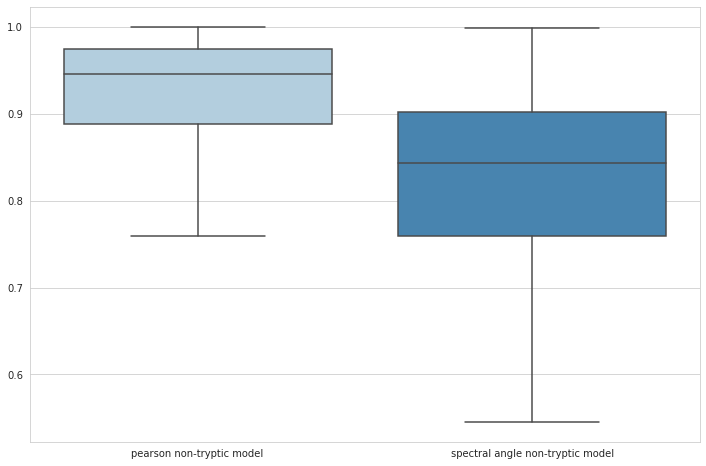

In [203]:
plt.figure(figsize=(12, 8))
model_perf = pd.DataFrame(columns=["pearson non-tryptic model", "spectral angle non-tryptic model"])
model_perf["pearson non-tryptic model"] = pear_corr
model_perf["spectral angle non-tryptic model"] = spec_corr
sns.set_style("whitegrid")
ax = sns.boxplot(data = model_perf, palette="Blues",showfliers = False)


plt.show()

# Performance on external tryptic and non-tryptic test set

In [207]:
predictions_tryptic = bst2.predict(tryptic_test)
predictions_non_tryptic = bst2.predict(non_tryptic_test)

In [208]:
tryptic_test_H = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
tryptic_hyperopt_model = Scorer(tryptic_psmids)
tryptic_test_H["pearson correlation"], tryptic_test_H["spectral angle"] = tryptic_hyperopt_model.psm_score(tryptic_targets,predictions_tryptic)
tryptic_test_H["type"] = "tryptic"

non_tryptic_test_H = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
non_tryptic_hyperopt_model = Scorer(non_tryptic_psmids)
non_tryptic_test_H["pearson correlation"], non_tryptic_test_H["spectral angle"] = non_tryptic_hyperopt_model.psm_score(non_tryptic_targets,predictions_non_tryptic)
non_tryptic_test_H["type"] = "non-tryptic"

Hyperopt_model_perf = pd.concat([tryptic_test_H, non_tryptic_test_H])
Hyperopt_model_perf["Model"] = "Hyperopt_model"

/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [209]:
model_comparison = pd.concat([Current_model_perf, New_model_perf, Hyperopt_model_perf])

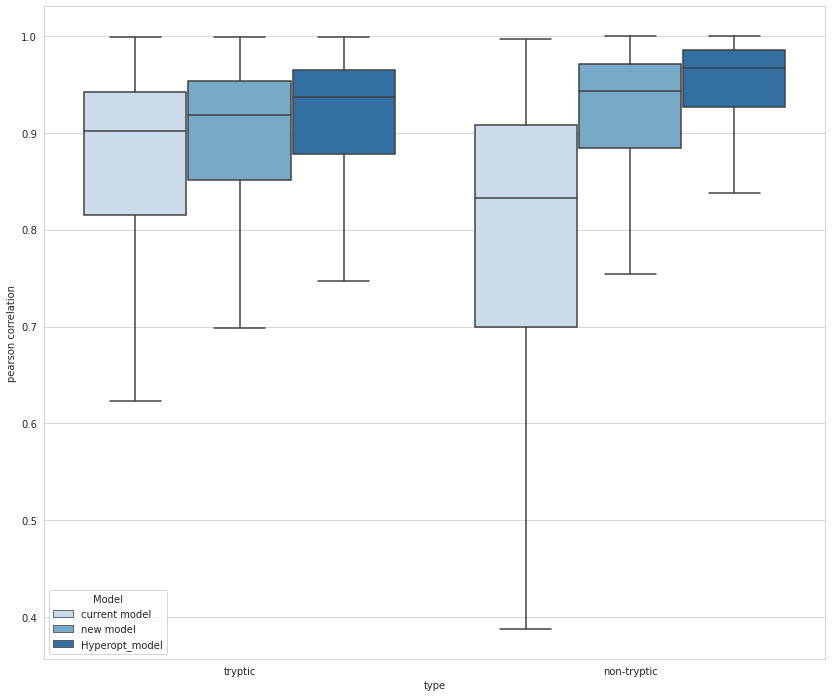

In [210]:
plt.figure(figsize=(14, 12))
sns.boxplot(data = model_comparison, x="type", y="pearson correlation", hue="Model", palette="Blues", showfliers = False)
plt.show()

In [212]:
print(f'PC tryptic hyperopt model: {(Hyperopt_model_perf["pearson correlation"][Hyperopt_model_perf.type == "tryptic"].median())}')
print(f'SA tryptic hyperopt model: {(Hyperopt_model_perf["spectral angle"][Hyperopt_model_perf.type == "tryptic"].median())}')
print(f'PC non-tryptic hyperopt model: {(Hyperopt_model_perf["pearson correlation"][Hyperopt_model_perf.type == "non-tryptic"].median())}')
print(f'SA non-tryptic hyperopt model: {(Hyperopt_model_perf["spectral angle"][Hyperopt_model_perf.type == "non-tryptic"].median())}')

PC tryptic hyperopt model: 0.9366453147371419
SA tryptic hyperopt model: 0.8115193621364316
PC non-tryptic hyperopt model: 0.9667237648678666
SA non-tryptic hyperopt model: 0.8864542466032427


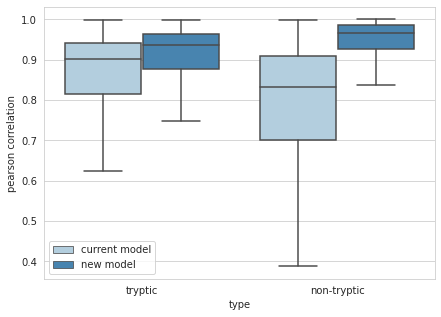

In [227]:
plt.figure(figsize=(7, 5))
sns.boxplot(data = model_comparison[(model_comparison.Model == "Hyperopt_model") | (model_comparison.Model == "current model") ], x="type", y="pearson correlation", hue="Model", palette="Blues", showfliers = False)
L=plt.legend()
L.get_texts()[1].set_text('new model')
plt.show()

# Learning curve hyperopt model

In [234]:
params

{'nthread': 64,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'eta': 0.0594145790364741,
 'max_depth': 17,
 'grow_policy': 'lossguide',
 'max_leaves': 302,
 'min_child_weight': 3,
 'gamma': 0.03338151150211477,
 'reg_lambda': 0.4430375595950531,
 'colsample_bytree': 0.9389820388602939,
 'subsample': 0.7000000000000001,
 'reg_alpha': 4.5}

In [235]:
train_ratios = [0.001,0.01,0.1,0.2,0.4,0.6,0.8,1]
train_upeps = train_psmids.unique()
np.random.shuffle(train_upeps)
learning_pred = dict({"test_psmids": test_psmids,"test_targets": test_targets})

for ratio in train_ratios:
    train_psm = train_upeps[:int(len(train_upeps) * ratio)]
    
    subset_train_vectors = train_vectors[train_psmids.isin(train_psm)]
    subset_train_targets = train_targets[train_psmids.isin(train_psm)]
    subset_train_psmids = train_psmids[train_psmids.isin(train_psm)]
    
    print(f"training on {len(subset_train_psmids.unique())} upeps")
    print(f"training vector: {len(subset_train_vectors)}")
    xtrain = xgb.DMatrix(subset_train_vectors, label=subset_train_targets)
    
    bst2 = xgb.train(params, xtrain, 400, maximize=False)
    model = str(len(subset_train_psmids.unique()))
    predictions = bst2.predict(xtest)
    learning_pred[model] = predictions
    
df = pd.DataFrame.from_dict(learning_pred)
df.to_csv("data/Hyperopt_Learning_curve_predictions.csv")

training on 414 upeps
training vector: 4904
training on 4141 upeps
training vector: 48855
training on 41417 upeps
training vector: 490199
training on 82834 upeps
training vector: 980487
training on 165668 upeps
training vector: 1964101
training on 248503 upeps
training vector: 2948196
training on 331337 upeps
training vector: 3931757
training on 414172 upeps
training vector: 4916054


In [236]:
learning_curve = pd.read_csv("data/Hyperopt_Learning_curve_predictions.csv", index_col=0)
learning_curve.head()

,test_psmids,test_targets,414,4141,41417,82834,165668,248503,331337,414172
108,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-6.782201,-7.421194,-6.759661,-6.592493,-6.416449,-6.315378,-6.435947,-6.523651,-6.347268
109,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-6.541206,-6.407582,-6.939172,-6.119307,-5.989660,-6.134331,-6.306375,-6.289200,-6.172865
110,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-7.689009,-7.749598,-7.587040,-7.123717,-7.200023,-7.648873,-7.278303,-7.831464,-7.467871
111,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-9.228428,-7.596363,-8.414605,-9.019712,-9.204418,-8.998049,-9.006763,-8.962566,-9.139458
112,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-6.569669,-6.660259,-6.869353,-6.874745,-7.109287,-6.982999,-6.524530,-6.538412,-6.661589


In [237]:
pearson_correlations = pd.DataFrame(columns=learning_curve.columns.drop(["test_psmids", "test_targets"]))
pearson = Scorer(learning_curve.test_psmids)
for training_pep in pearson_correlations.columns:
    pearson_correlations[training_pep], _ = pearson.psm_score(learning_curve["test_targets"], learning_curve[training_pep])
    

/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


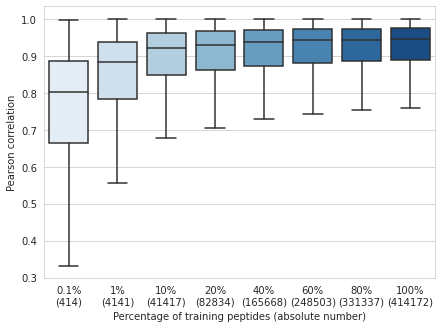

In [242]:
train_ratios = ["0.1%\n(414)","1%\n(4141)","10%\n(41417)","20%\n(82834)","40%\n(165668)","60%\n(248503)","80%\n(331337)","100%\n(414172)"]
plt.figure(figsize=(7, 5))
ax = sns.boxplot(data = pearson_correlations, palette="Blues",showfliers = False)
ax.set_xticklabels(train_ratios)
plt.ylabel('Pearson correlation')
plt.xlabel('Percentage of training peptides (absolute number)')
sns.set_style("whitegrid")
plt.show()

# Less in depth model

In [244]:
space= {
    'eta': hp.loguniform('eta', np.log(0.01), np.log(1)),
    'max_depth': hp.quniform('max_depth', 2, 7, 1),
    'max_leaves': hp.quniform('max_leaves', 5, 500, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'gamma' : hp.uniform ('gamma', 0.0,1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 500, 1),
    'subsample': hp.quniform('subsample', 0.5, 1 ,0.1),
    'reg_alpha': hp.quniform('reg_alpha', 0, 5 ,0.1),
    'grow_policy': hp.choice('grow_policy', ("lossguide", "depthwise"))
}

In [245]:
def objective(space):
    params = {
    "nthread": 64,
    "objective": "reg:squarederror",
    "eval_metric": 'rmse',
    "eta": space["eta"],
    "max_depth": int(space['max_depth']),
    "grow_policy":space['grow_policy'],
    "max_leaves":int(space["max_leaves"]),
    "min_child_weight": int(space["min_child_weight"]),
    "gamma": space['gamma'],
    "reg_lambda" : space['reg_lambda'],
    "colsample_bytree": space['colsample_bytree'],
    "subsample" : space["subsample"],
    "reg_alpha" : space["reg_alpha"]
    }
    print(params)
    tmp = xgb.cv(params, xtrain, nfold=4, num_boost_round=400, early_stopping_rounds=10, verbose_eval=True)
    rmse = tmp['test-rmse-mean'].min()

    print ("rmse:", rmse)
    return {'loss': rmse, 'status': STATUS_OK, "params": params}

In [246]:
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 30,
                        trials = trials)


best_hyperparams

{'nthread': 64, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.22631030282577397, 'max_depth': 7, 'grow_policy': 'depthwise', 'max_leaves': 338, 'min_child_weight': 82, 'gamma': 0.45560314943066327, 'reg_lambda': 0.9778498555268148, 'colsample_bytree': 0.8527560122350772, 'subsample': 0.6000000000000001, 'reg_alpha': 3.7}
[0]	train-rmse:6.87384+0.00033	test-rmse:6.87399+0.00061

[1]	train-rmse:5.39672+0.00074	test-rmse:5.39665+0.00076

[2]	train-rmse:4.26923+0.00055	test-rmse:4.26918+0.00066

[3]	train-rmse:3.41641+0.00037	test-rmse:3.41650+0.00082

[4]	train-rmse:2.77831+0.00155	test-rmse:2.77844+0.00164

[5]	train-rmse:2.30714+0.00319	test-rmse:2.30739+0.00219

[6]	train-rmse:1.96369+0.00403	test-rmse:1.96400+0.00375

[7]	train-rmse:1.72335+0.00165	test-rmse:1.72373+0.00192

[8]	train-rmse:1.55500+0.00486	test-rmse:1.55556+0.00330

[9]	train-rmse:1.44241+0.00260	test-rmse:1.44307+0.00117

[10]	train-rmse:1.36122+0.00306	test-rmse:1.36201+0.00199

[11]	train-rmse:1.3

[268]	train-rmse:0.95621+0.00084	test-rmse:0.96831+0.00099

[269]	train-rmse:0.95602+0.00087	test-rmse:0.96817+0.00104

[270]	train-rmse:0.95582+0.00095	test-rmse:0.96800+0.00112

[271]	train-rmse:0.95556+0.00089	test-rmse:0.96778+0.00105

[272]	train-rmse:0.95531+0.00095	test-rmse:0.96757+0.00108

[273]	train-rmse:0.95511+0.00098	test-rmse:0.96740+0.00110

[274]	train-rmse:0.95492+0.00097	test-rmse:0.96724+0.00103

[275]	train-rmse:0.95473+0.00105	test-rmse:0.96708+0.00111

[276]	train-rmse:0.95448+0.00112	test-rmse:0.96688+0.00120

[277]	train-rmse:0.95421+0.00121	test-rmse:0.96664+0.00126

[278]	train-rmse:0.95404+0.00125	test-rmse:0.96651+0.00128

[279]	train-rmse:0.95380+0.00125	test-rmse:0.96631+0.00127

[280]	train-rmse:0.95365+0.00126	test-rmse:0.96620+0.00127

[281]	train-rmse:0.95343+0.00132	test-rmse:0.96603+0.00134

[282]	train-rmse:0.95321+0.00132	test-rmse:0.96584+0.00131

[283]	train-rmse:0.95289+0.00121	test-rmse:0.96555+0.00123

[284]	train-rmse:0.95271+0.00121	test-rm

[0]	train-rmse:8.69476+0.00027	test-rmse:8.69498+0.00081                             

[1]	train-rmse:8.58976+0.00023	test-rmse:8.58947+0.00082                             

[2]	train-rmse:8.48520+0.00020	test-rmse:8.48536+0.00079                             

[3]	train-rmse:8.38247+0.00022	test-rmse:8.38261+0.00076                             

[4]	train-rmse:8.28115+0.00035	test-rmse:8.28115+0.00073                             

[5]	train-rmse:8.18102+0.00028	test-rmse:8.18101+0.00075                             

[6]	train-rmse:8.08208+0.00028	test-rmse:8.08223+0.00077                             

[7]	train-rmse:7.98474+0.00044	test-rmse:7.98476+0.00075                             

[8]	train-rmse:7.88846+0.00043	test-rmse:7.88854+0.00072                             

[9]	train-rmse:7.79345+0.00039	test-rmse:7.79360+0.00088                             

[10]	train-rmse:7.69975+0.00025	test-rmse:7.69979+0.00091                            

[11]	train-rmse:7.60729+0.00036	test-rmse:7

[187]	train-rmse:1.61027+0.00092	test-rmse:1.61052+0.00157                             

[188]	train-rmse:1.60451+0.00099	test-rmse:1.60476+0.00169                             

[189]	train-rmse:1.59892+0.00096	test-rmse:1.59917+0.00165                             

[190]	train-rmse:1.59346+0.00101	test-rmse:1.59371+0.00170                             

[191]	train-rmse:1.58801+0.00088	test-rmse:1.58827+0.00168                             

[192]	train-rmse:1.58247+0.00092	test-rmse:1.58273+0.00158                             

[193]	train-rmse:1.57730+0.00107	test-rmse:1.57756+0.00168                             

[194]	train-rmse:1.57216+0.00116	test-rmse:1.57243+0.00170                             

[195]	train-rmse:1.56699+0.00118	test-rmse:1.56726+0.00175                             

[196]	train-rmse:1.56220+0.00117	test-rmse:1.56247+0.00178                             

[197]	train-rmse:1.55744+0.00134	test-rmse:1.55771+0.00189                             

[198]	train-rmse:1.55

[371]	train-rmse:1.28955+0.00053	test-rmse:1.29002+0.00159                             

[372]	train-rmse:1.28915+0.00067	test-rmse:1.28962+0.00169                             

[373]	train-rmse:1.28871+0.00069	test-rmse:1.28918+0.00162                             

[374]	train-rmse:1.28828+0.00069	test-rmse:1.28875+0.00159                             

[375]	train-rmse:1.28792+0.00070	test-rmse:1.28839+0.00163                             

[376]	train-rmse:1.28744+0.00060	test-rmse:1.28791+0.00158                             

[377]	train-rmse:1.28697+0.00059	test-rmse:1.28744+0.00150                             

[378]	train-rmse:1.28651+0.00065	test-rmse:1.28698+0.00145                             

[379]	train-rmse:1.28615+0.00066	test-rmse:1.28662+0.00148                             

[380]	train-rmse:1.28561+0.00057	test-rmse:1.28608+0.00154                             

[381]	train-rmse:1.28514+0.00046	test-rmse:1.28561+0.00153                             

[382]	train-rmse:1.28

[149]	train-rmse:1.30671+0.00126	test-rmse:1.30703+0.00173                             

[150]	train-rmse:1.30628+0.00133	test-rmse:1.30660+0.00179                             

[151]	train-rmse:1.30560+0.00121	test-rmse:1.30594+0.00170                             

[152]	train-rmse:1.30488+0.00122	test-rmse:1.30523+0.00158                             

[153]	train-rmse:1.30438+0.00131	test-rmse:1.30473+0.00169                             

[154]	train-rmse:1.30392+0.00139	test-rmse:1.30427+0.00171                             

[155]	train-rmse:1.30355+0.00159	test-rmse:1.30390+0.00183                             

[156]	train-rmse:1.30313+0.00183	test-rmse:1.30349+0.00204                             

[157]	train-rmse:1.30272+0.00186	test-rmse:1.30309+0.00202                             

[158]	train-rmse:1.30224+0.00189	test-rmse:1.30261+0.00199                             

[159]	train-rmse:1.30187+0.00183	test-rmse:1.30226+0.00197                             

[160]	train-rmse:1.30

[333]	train-rmse:1.24338+0.00222	test-rmse:1.24386+0.00326                             

[334]	train-rmse:1.24317+0.00219	test-rmse:1.24364+0.00322                             

[335]	train-rmse:1.24294+0.00212	test-rmse:1.24342+0.00316                             

[336]	train-rmse:1.24272+0.00212	test-rmse:1.24319+0.00316                             

[337]	train-rmse:1.24251+0.00207	test-rmse:1.24298+0.00313                             

[338]	train-rmse:1.24234+0.00206	test-rmse:1.24281+0.00313                             

[339]	train-rmse:1.24221+0.00206	test-rmse:1.24268+0.00312                             

[340]	train-rmse:1.24200+0.00202	test-rmse:1.24248+0.00308                             

[341]	train-rmse:1.24184+0.00201	test-rmse:1.24232+0.00306                             

[342]	train-rmse:1.24152+0.00213	test-rmse:1.24199+0.00316                             

[343]	train-rmse:1.24118+0.00211	test-rmse:1.24165+0.00316                             

[344]	train-rmse:1.24

[111]	train-rmse:1.04445+0.00169	test-rmse:1.04829+0.00122                             

[112]	train-rmse:1.04390+0.00175	test-rmse:1.04777+0.00130                             

[113]	train-rmse:1.04344+0.00162	test-rmse:1.04733+0.00116                             

[114]	train-rmse:1.04287+0.00198	test-rmse:1.04680+0.00147                             

[115]	train-rmse:1.04226+0.00183	test-rmse:1.04624+0.00135                             

[116]	train-rmse:1.04166+0.00162	test-rmse:1.04565+0.00111                             

[117]	train-rmse:1.04107+0.00154	test-rmse:1.04510+0.00107                             

[118]	train-rmse:1.04055+0.00145	test-rmse:1.04461+0.00100                             

[119]	train-rmse:1.04017+0.00125	test-rmse:1.04424+0.00080                             

[120]	train-rmse:1.03983+0.00125	test-rmse:1.04394+0.00078                             

[121]	train-rmse:1.03940+0.00115	test-rmse:1.04352+0.00079                             

[122]	train-rmse:1.03

[295]	train-rmse:0.98254+0.00129	test-rmse:0.99116+0.00143                             

[296]	train-rmse:0.98231+0.00125	test-rmse:0.99094+0.00143                             

[297]	train-rmse:0.98213+0.00124	test-rmse:0.99079+0.00141                             

[298]	train-rmse:0.98196+0.00125	test-rmse:0.99064+0.00142                             

[299]	train-rmse:0.98185+0.00129	test-rmse:0.99055+0.00146                             

[300]	train-rmse:0.98166+0.00126	test-rmse:0.99040+0.00140                             

[301]	train-rmse:0.98151+0.00130	test-rmse:0.99027+0.00143                             

[302]	train-rmse:0.98127+0.00141	test-rmse:0.99005+0.00158                             

[303]	train-rmse:0.98117+0.00141	test-rmse:0.98998+0.00159                             

[304]	train-rmse:0.98095+0.00152	test-rmse:0.98979+0.00171                             

[305]	train-rmse:0.98076+0.00152	test-rmse:0.98962+0.00172                             

[306]	train-rmse:0.98

[73]	train-rmse:1.29665+0.00184	test-rmse:1.29700+0.00248                              

[74]	train-rmse:1.29499+0.00175	test-rmse:1.29534+0.00245                              

[75]	train-rmse:1.29347+0.00203	test-rmse:1.29380+0.00267                              

[76]	train-rmse:1.29213+0.00165	test-rmse:1.29246+0.00217                              

[77]	train-rmse:1.29007+0.00157	test-rmse:1.29042+0.00196                              

[78]	train-rmse:1.28808+0.00140	test-rmse:1.28844+0.00188                              

[79]	train-rmse:1.28632+0.00163	test-rmse:1.28670+0.00224                              

[80]	train-rmse:1.28429+0.00157	test-rmse:1.28467+0.00240                              

[81]	train-rmse:1.28304+0.00132	test-rmse:1.28343+0.00212                              

[82]	train-rmse:1.28113+0.00133	test-rmse:1.28152+0.00249                              

[83]	train-rmse:1.27981+0.00129	test-rmse:1.28022+0.00241                              

[84]	train-rmse:1.278

[257]	train-rmse:1.16464+0.00212	test-rmse:1.16554+0.00220                             

[258]	train-rmse:1.16438+0.00209	test-rmse:1.16528+0.00218                             

[259]	train-rmse:1.16409+0.00228	test-rmse:1.16499+0.00236                             

[260]	train-rmse:1.16368+0.00243	test-rmse:1.16458+0.00256                             

[261]	train-rmse:1.16332+0.00235	test-rmse:1.16423+0.00252                             

[262]	train-rmse:1.16299+0.00216	test-rmse:1.16389+0.00235                             

[263]	train-rmse:1.16271+0.00210	test-rmse:1.16363+0.00233                             

[264]	train-rmse:1.16227+0.00211	test-rmse:1.16319+0.00235                             

[265]	train-rmse:1.16206+0.00204	test-rmse:1.16297+0.00229                             

[266]	train-rmse:1.16148+0.00223	test-rmse:1.16240+0.00245                             

[267]	train-rmse:1.16108+0.00224	test-rmse:1.16201+0.00248                             

[268]	train-rmse:1.16

[35]	train-rmse:2.07108+0.00160	test-rmse:2.07148+0.00217                              

[36]	train-rmse:2.01163+0.00140	test-rmse:2.01205+0.00182                              

[37]	train-rmse:1.95670+0.00165	test-rmse:1.95715+0.00211                              

[38]	train-rmse:1.90495+0.00173	test-rmse:1.90541+0.00231                              

[39]	train-rmse:1.85655+0.00107	test-rmse:1.85702+0.00226                              

[40]	train-rmse:1.81074+0.00133	test-rmse:1.81124+0.00219                              

[41]	train-rmse:1.76840+0.00185	test-rmse:1.76892+0.00265                              

[42]	train-rmse:1.72905+0.00197	test-rmse:1.72958+0.00269                              

[43]	train-rmse:1.69136+0.00237	test-rmse:1.69191+0.00315                              

[44]	train-rmse:1.65653+0.00171	test-rmse:1.65711+0.00286                              

[45]	train-rmse:1.62441+0.00197	test-rmse:1.62501+0.00311                              

[46]	train-rmse:1.592

[219]	train-rmse:1.06934+0.00096	test-rmse:1.07178+0.00146                             

[220]	train-rmse:1.06886+0.00094	test-rmse:1.07132+0.00140                             

[221]	train-rmse:1.06848+0.00077	test-rmse:1.07094+0.00131                             

[222]	train-rmse:1.06802+0.00075	test-rmse:1.07049+0.00126                             

[223]	train-rmse:1.06776+0.00084	test-rmse:1.07023+0.00133                             

[224]	train-rmse:1.06743+0.00078	test-rmse:1.06991+0.00126                             

[225]	train-rmse:1.06702+0.00088	test-rmse:1.06951+0.00128                             

[226]	train-rmse:1.06658+0.00086	test-rmse:1.06908+0.00129                             

[227]	train-rmse:1.06616+0.00076	test-rmse:1.06866+0.00121                             

[228]	train-rmse:1.06573+0.00066	test-rmse:1.06824+0.00120                             

[229]	train-rmse:1.06531+0.00066	test-rmse:1.06783+0.00122                             

[230]	train-rmse:1.06

[0]	train-rmse:7.90473+0.00031	test-rmse:7.90491+0.00069                               

[1]	train-rmse:7.10684+0.00100	test-rmse:7.10668+0.00104                               

[2]	train-rmse:6.39603+0.00122	test-rmse:6.39594+0.00111                               

[3]	train-rmse:5.76396+0.00091	test-rmse:5.76401+0.00063                               

[4]	train-rmse:5.20353+0.00155	test-rmse:5.20354+0.00123                               

[5]	train-rmse:4.70630+0.00121	test-rmse:4.70629+0.00069                               

[6]	train-rmse:4.26681+0.00144	test-rmse:4.26678+0.00115                               

[7]	train-rmse:3.87902+0.00150	test-rmse:3.87899+0.00130                               

[8]	train-rmse:3.53723+0.00186	test-rmse:3.53723+0.00180                               

[9]	train-rmse:3.23714+0.00158	test-rmse:3.23713+0.00170                               

[10]	train-rmse:2.97393+0.00087	test-rmse:2.97398+0.00102                              

[11]	train-rmse:2.744

[184]	train-rmse:1.19369+0.00163	test-rmse:1.19427+0.00231                             

[185]	train-rmse:1.19311+0.00164	test-rmse:1.19370+0.00229                             

[186]	train-rmse:1.19261+0.00157	test-rmse:1.19321+0.00220                             

[187]	train-rmse:1.19206+0.00151	test-rmse:1.19266+0.00196                             

[188]	train-rmse:1.19156+0.00144	test-rmse:1.19216+0.00190                             

[189]	train-rmse:1.19118+0.00148	test-rmse:1.19178+0.00193                             

[190]	train-rmse:1.19089+0.00150	test-rmse:1.19149+0.00196                             

[191]	train-rmse:1.19023+0.00132	test-rmse:1.19084+0.00191                             

[192]	train-rmse:1.18995+0.00138	test-rmse:1.19056+0.00196                             

[193]	train-rmse:1.18943+0.00145	test-rmse:1.19005+0.00209                             

[194]	train-rmse:1.18905+0.00145	test-rmse:1.18968+0.00209                             

[195]	train-rmse:1.18

[368]	train-rmse:1.13094+0.00130	test-rmse:1.13203+0.00070                             

[369]	train-rmse:1.13070+0.00130	test-rmse:1.13178+0.00075                             

[370]	train-rmse:1.13056+0.00128	test-rmse:1.13165+0.00079                             

[371]	train-rmse:1.13034+0.00125	test-rmse:1.13143+0.00078                             

[372]	train-rmse:1.13009+0.00129	test-rmse:1.13119+0.00077                             

[373]	train-rmse:1.12978+0.00127	test-rmse:1.13087+0.00076                             

[374]	train-rmse:1.12951+0.00130	test-rmse:1.13062+0.00080                             

[375]	train-rmse:1.12935+0.00135	test-rmse:1.13046+0.00084                             

[376]	train-rmse:1.12916+0.00135	test-rmse:1.13028+0.00091                             

[377]	train-rmse:1.12897+0.00134	test-rmse:1.13008+0.00096                             

[378]	train-rmse:1.12881+0.00134	test-rmse:1.12993+0.00096                             

[379]	train-rmse:1.12

[146]	train-rmse:1.02128+0.00271	test-rmse:1.04370+0.00233                             

[147]	train-rmse:1.02088+0.00267	test-rmse:1.04348+0.00228                             

[148]	train-rmse:1.02055+0.00262	test-rmse:1.04330+0.00230                             

[149]	train-rmse:1.02022+0.00261	test-rmse:1.04313+0.00232                             

[150]	train-rmse:1.01997+0.00262	test-rmse:1.04299+0.00235                             

[151]	train-rmse:1.01965+0.00261	test-rmse:1.04283+0.00237                             

[152]	train-rmse:1.01933+0.00272	test-rmse:1.04258+0.00248                             

[153]	train-rmse:1.01908+0.00272	test-rmse:1.04245+0.00250                             

[154]	train-rmse:1.01887+0.00272	test-rmse:1.04236+0.00252                             

[155]	train-rmse:1.01859+0.00271	test-rmse:1.04223+0.00250                             

[156]	train-rmse:1.01839+0.00271	test-rmse:1.04214+0.00252                             

[157]	train-rmse:1.01

[330]	train-rmse:0.98102+0.00368	test-rmse:1.02522+0.00352                             

[331]	train-rmse:0.98083+0.00365	test-rmse:1.02515+0.00349                             

[332]	train-rmse:0.98069+0.00364	test-rmse:1.02514+0.00347                             

[333]	train-rmse:0.98056+0.00365	test-rmse:1.02511+0.00345                             

[334]	train-rmse:0.98046+0.00364	test-rmse:1.02507+0.00344                             

[335]	train-rmse:0.98029+0.00360	test-rmse:1.02501+0.00339                             

[336]	train-rmse:0.98017+0.00357	test-rmse:1.02500+0.00338                             

[337]	train-rmse:0.97998+0.00359	test-rmse:1.02494+0.00337                             

[338]	train-rmse:0.97985+0.00360	test-rmse:1.02491+0.00336                             

[339]	train-rmse:0.97975+0.00360	test-rmse:1.02491+0.00340                             

[340]	train-rmse:0.97960+0.00361	test-rmse:1.02489+0.00337                             

[341]	train-rmse:0.97

[108]	train-rmse:1.19173+0.00132	test-rmse:1.19239+0.00101                             

[109]	train-rmse:1.19060+0.00151	test-rmse:1.19128+0.00126                             

[110]	train-rmse:1.18974+0.00138	test-rmse:1.19043+0.00113                             

[111]	train-rmse:1.18872+0.00157	test-rmse:1.18941+0.00149                             

[112]	train-rmse:1.18784+0.00170	test-rmse:1.18854+0.00145                             

[113]	train-rmse:1.18703+0.00176	test-rmse:1.18773+0.00138                             

[114]	train-rmse:1.18611+0.00132	test-rmse:1.18682+0.00089                             

[115]	train-rmse:1.18504+0.00154	test-rmse:1.18576+0.00087                             

[116]	train-rmse:1.18423+0.00133	test-rmse:1.18494+0.00057                             

[117]	train-rmse:1.18347+0.00148	test-rmse:1.18420+0.00069                             

[118]	train-rmse:1.18251+0.00139	test-rmse:1.18325+0.00056                             

[119]	train-rmse:1.18

[292]	train-rmse:1.09819+0.00088	test-rmse:1.09967+0.00093                             

[293]	train-rmse:1.09799+0.00086	test-rmse:1.09947+0.00092                             

[294]	train-rmse:1.09770+0.00077	test-rmse:1.09917+0.00082                             

[295]	train-rmse:1.09737+0.00083	test-rmse:1.09885+0.00090                             

[296]	train-rmse:1.09706+0.00082	test-rmse:1.09854+0.00096                             

[297]	train-rmse:1.09680+0.00086	test-rmse:1.09828+0.00104                             

[298]	train-rmse:1.09649+0.00093	test-rmse:1.09798+0.00099                             

[299]	train-rmse:1.09614+0.00095	test-rmse:1.09764+0.00105                             

[300]	train-rmse:1.09586+0.00097	test-rmse:1.09736+0.00106                             

[301]	train-rmse:1.09557+0.00098	test-rmse:1.09708+0.00112                             

[302]	train-rmse:1.09525+0.00096	test-rmse:1.09677+0.00112                             

[303]	train-rmse:1.09

[70]	train-rmse:1.31175+0.00384	test-rmse:1.31201+0.00316                              

[71]	train-rmse:1.30981+0.00373	test-rmse:1.31008+0.00296                              

[72]	train-rmse:1.30869+0.00364	test-rmse:1.30896+0.00285                              

[73]	train-rmse:1.30724+0.00415	test-rmse:1.30751+0.00348                              

[74]	train-rmse:1.30545+0.00396	test-rmse:1.30572+0.00316                              

[75]	train-rmse:1.30400+0.00404	test-rmse:1.30427+0.00326                              

[76]	train-rmse:1.30240+0.00428	test-rmse:1.30266+0.00353                              

[77]	train-rmse:1.30109+0.00426	test-rmse:1.30138+0.00348                              

[78]	train-rmse:1.29972+0.00464	test-rmse:1.30000+0.00382                              

[79]	train-rmse:1.29821+0.00410	test-rmse:1.29851+0.00330                              

[80]	train-rmse:1.29712+0.00416	test-rmse:1.29741+0.00339                              

[81]	train-rmse:1.296

[254]	train-rmse:1.19214+0.00198	test-rmse:1.19267+0.00204                             

[255]	train-rmse:1.19162+0.00185	test-rmse:1.19216+0.00200                             

[256]	train-rmse:1.19131+0.00186	test-rmse:1.19185+0.00200                             

[257]	train-rmse:1.19102+0.00182	test-rmse:1.19156+0.00194                             

[258]	train-rmse:1.19070+0.00182	test-rmse:1.19123+0.00198                             

[259]	train-rmse:1.18998+0.00203	test-rmse:1.19052+0.00186                             

[260]	train-rmse:1.18974+0.00193	test-rmse:1.19028+0.00175                             

[261]	train-rmse:1.18940+0.00203	test-rmse:1.18994+0.00178                             

[262]	train-rmse:1.18906+0.00209	test-rmse:1.18959+0.00180                             

[263]	train-rmse:1.18875+0.00205	test-rmse:1.18929+0.00179                             

[264]	train-rmse:1.18839+0.00204	test-rmse:1.18892+0.00182                             

[265]	train-rmse:1.18

[32]	train-rmse:1.12414+0.00294	test-rmse:1.12705+0.00337                              

[33]	train-rmse:1.12194+0.00240	test-rmse:1.12496+0.00273                              

[34]	train-rmse:1.11846+0.00352	test-rmse:1.12148+0.00352                              

[35]	train-rmse:1.11624+0.00295	test-rmse:1.11934+0.00297                              

[36]	train-rmse:1.11379+0.00257	test-rmse:1.11696+0.00249                              

[37]	train-rmse:1.11173+0.00225	test-rmse:1.11499+0.00227                              

[38]	train-rmse:1.10991+0.00215	test-rmse:1.11322+0.00202                              

[39]	train-rmse:1.10804+0.00169	test-rmse:1.11141+0.00175                              

[40]	train-rmse:1.10623+0.00226	test-rmse:1.10964+0.00204                              

[41]	train-rmse:1.10466+0.00215	test-rmse:1.10815+0.00175                              

[42]	train-rmse:1.10356+0.00177	test-rmse:1.10715+0.00134                              

[43]	train-rmse:1.102

[216]	train-rmse:0.99339+0.00125	test-rmse:1.00895+0.00168                             

[217]	train-rmse:0.99309+0.00130	test-rmse:1.00871+0.00178                             

[218]	train-rmse:0.99274+0.00134	test-rmse:1.00845+0.00176                             

[219]	train-rmse:0.99243+0.00139	test-rmse:1.00821+0.00174                             

[220]	train-rmse:0.99222+0.00133	test-rmse:1.00805+0.00169                             

[221]	train-rmse:0.99187+0.00130	test-rmse:1.00779+0.00161                             

[222]	train-rmse:0.99154+0.00129	test-rmse:1.00755+0.00159                             

[223]	train-rmse:0.99131+0.00127	test-rmse:1.00739+0.00159                             

[224]	train-rmse:0.99106+0.00126	test-rmse:1.00719+0.00159                             

[225]	train-rmse:0.99085+0.00123	test-rmse:1.00707+0.00159                             

[226]	train-rmse:0.99048+0.00129	test-rmse:1.00675+0.00168                             

[227]	train-rmse:0.99

rmse:                                                                                  
0.9820724999999999                                                                     
{'nthread': 64, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.22822837194637755, 'max_depth': 2, 'grow_policy': 'lossguide', 'max_leaves': 380, 'min_child_weight': 298, 'gamma': 0.7428933287115481, 'reg_lambda': 0.47344983361751647, 'colsample_bytree': 0.70244749342533, 'subsample': 0.5, 'reg_alpha': 2.6}
[0]	train-rmse:6.88916+0.00037	test-rmse:6.88872+0.00059                               

[1]	train-rmse:5.43487+0.00064	test-rmse:5.43506+0.00081                               

[2]	train-rmse:4.33947+0.00120	test-rmse:4.33948+0.00145                               

[3]	train-rmse:3.52490+0.00155	test-rmse:3.52495+0.00139                               

[4]	train-rmse:2.92763+0.00179	test-rmse:2.92765+0.00113                               

[5]	train-rmse:2.50076+0.00116	test-rmse:2.50075+0.00

[178]	train-rmse:1.31876+0.00137	test-rmse:1.31904+0.00178                             

[179]	train-rmse:1.31826+0.00150	test-rmse:1.31853+0.00178                             

[180]	train-rmse:1.31769+0.00141	test-rmse:1.31796+0.00178                             

[181]	train-rmse:1.31743+0.00145	test-rmse:1.31771+0.00185                             

[182]	train-rmse:1.31699+0.00141	test-rmse:1.31726+0.00179                             

[183]	train-rmse:1.31651+0.00133	test-rmse:1.31680+0.00162                             

[184]	train-rmse:1.31625+0.00132	test-rmse:1.31655+0.00153                             

[185]	train-rmse:1.31571+0.00147	test-rmse:1.31601+0.00163                             

[186]	train-rmse:1.31544+0.00155	test-rmse:1.31574+0.00172                             

[187]	train-rmse:1.31511+0.00151	test-rmse:1.31540+0.00176                             

[188]	train-rmse:1.31467+0.00130	test-rmse:1.31497+0.00170                             

[189]	train-rmse:1.31

[362]	train-rmse:1.26194+0.00190	test-rmse:1.26232+0.00222                             

[363]	train-rmse:1.26179+0.00195	test-rmse:1.26218+0.00227                             

[364]	train-rmse:1.26168+0.00196	test-rmse:1.26207+0.00227                             

[365]	train-rmse:1.26145+0.00196	test-rmse:1.26184+0.00228                             

[366]	train-rmse:1.26121+0.00201	test-rmse:1.26159+0.00233                             

[367]	train-rmse:1.26083+0.00216	test-rmse:1.26120+0.00247                             

[368]	train-rmse:1.26066+0.00211	test-rmse:1.26104+0.00238                             

[369]	train-rmse:1.26051+0.00210	test-rmse:1.26089+0.00239                             

[370]	train-rmse:1.26022+0.00193	test-rmse:1.26061+0.00228                             

[371]	train-rmse:1.26002+0.00196	test-rmse:1.26040+0.00227                             

[372]	train-rmse:1.25979+0.00198	test-rmse:1.26017+0.00224                             

[373]	train-rmse:1.25

[140]	train-rmse:1.02484+0.00072	test-rmse:1.02923+0.00127                             

[141]	train-rmse:1.02437+0.00076	test-rmse:1.02879+0.00134                             

[142]	train-rmse:1.02382+0.00084	test-rmse:1.02827+0.00132                             

[143]	train-rmse:1.02298+0.00111	test-rmse:1.02746+0.00144                             

[144]	train-rmse:1.02256+0.00127	test-rmse:1.02707+0.00154                             

[145]	train-rmse:1.02209+0.00136	test-rmse:1.02662+0.00164                             

[146]	train-rmse:1.02148+0.00127	test-rmse:1.02604+0.00147                             

[147]	train-rmse:1.02109+0.00125	test-rmse:1.02569+0.00141                             

[148]	train-rmse:1.02085+0.00138	test-rmse:1.02547+0.00153                             

[149]	train-rmse:1.02033+0.00137	test-rmse:1.02499+0.00158                             

[150]	train-rmse:1.01994+0.00117	test-rmse:1.02463+0.00142                             

[151]	train-rmse:1.01

[324]	train-rmse:0.97358+0.00125	test-rmse:0.98252+0.00121                             

[325]	train-rmse:0.97334+0.00131	test-rmse:0.98231+0.00126                             

[326]	train-rmse:0.97314+0.00131	test-rmse:0.98213+0.00121                             

[327]	train-rmse:0.97300+0.00132	test-rmse:0.98201+0.00121                             

[328]	train-rmse:0.97285+0.00133	test-rmse:0.98188+0.00122                             

[329]	train-rmse:0.97270+0.00133	test-rmse:0.98175+0.00122                             

[330]	train-rmse:0.97246+0.00127	test-rmse:0.98153+0.00115                             

[331]	train-rmse:0.97231+0.00129	test-rmse:0.98141+0.00115                             

[332]	train-rmse:0.97214+0.00120	test-rmse:0.98126+0.00107                             

[333]	train-rmse:0.97193+0.00110	test-rmse:0.98108+0.00096                             

[334]	train-rmse:0.97180+0.00106	test-rmse:0.98098+0.00095                             

[335]	train-rmse:0.97

[102]	train-rmse:1.17465+0.00118	test-rmse:1.17564+0.00214                             

[103]	train-rmse:1.17353+0.00114	test-rmse:1.17454+0.00207                             

[104]	train-rmse:1.17235+0.00118	test-rmse:1.17336+0.00210                             

[105]	train-rmse:1.17089+0.00148	test-rmse:1.17190+0.00234                             

[106]	train-rmse:1.16984+0.00152	test-rmse:1.17086+0.00241                             

[107]	train-rmse:1.16801+0.00150	test-rmse:1.16904+0.00263                             

[108]	train-rmse:1.16659+0.00166	test-rmse:1.16762+0.00276                             

[109]	train-rmse:1.16563+0.00164	test-rmse:1.16668+0.00275                             

[110]	train-rmse:1.16471+0.00158	test-rmse:1.16576+0.00268                             

[111]	train-rmse:1.16348+0.00143	test-rmse:1.16453+0.00254                             

[112]	train-rmse:1.16218+0.00123	test-rmse:1.16322+0.00220                             

[113]	train-rmse:1.16

[286]	train-rmse:1.07136+0.00068	test-rmse:1.07365+0.00143                             

[287]	train-rmse:1.07106+0.00064	test-rmse:1.07335+0.00141                             

[288]	train-rmse:1.07079+0.00063	test-rmse:1.07310+0.00140                             

[289]	train-rmse:1.07033+0.00058	test-rmse:1.07265+0.00132                             

[290]	train-rmse:1.07007+0.00066	test-rmse:1.07240+0.00142                             

[291]	train-rmse:1.06984+0.00066	test-rmse:1.07217+0.00140                             

[292]	train-rmse:1.06946+0.00068	test-rmse:1.07180+0.00145                             

[293]	train-rmse:1.06905+0.00081	test-rmse:1.07140+0.00156                             

[294]	train-rmse:1.06877+0.00081	test-rmse:1.07112+0.00157                             

[295]	train-rmse:1.06852+0.00074	test-rmse:1.07087+0.00151                             

[296]	train-rmse:1.06828+0.00078	test-rmse:1.07064+0.00156                             

[297]	train-rmse:1.06

[64]	train-rmse:1.17373+0.00282	test-rmse:1.17454+0.00331                              

[65]	train-rmse:1.17236+0.00316	test-rmse:1.17318+0.00357                              

[66]	train-rmse:1.17053+0.00328	test-rmse:1.17136+0.00357                              

[67]	train-rmse:1.16862+0.00296	test-rmse:1.16946+0.00306                              

[68]	train-rmse:1.16747+0.00324	test-rmse:1.16833+0.00323                              

[69]	train-rmse:1.16516+0.00397	test-rmse:1.16604+0.00361                              

[70]	train-rmse:1.16378+0.00338	test-rmse:1.16466+0.00318                              

[71]	train-rmse:1.16229+0.00370	test-rmse:1.16317+0.00352                              

[72]	train-rmse:1.16084+0.00399	test-rmse:1.16174+0.00383                              

[73]	train-rmse:1.15948+0.00362	test-rmse:1.16038+0.00350                              

[74]	train-rmse:1.15827+0.00341	test-rmse:1.15920+0.00345                              

[75]	train-rmse:1.157

[248]	train-rmse:1.06165+0.00166	test-rmse:1.06395+0.00146                             

[249]	train-rmse:1.06117+0.00162	test-rmse:1.06347+0.00145                             

[250]	train-rmse:1.06083+0.00165	test-rmse:1.06314+0.00139                             

[251]	train-rmse:1.06063+0.00170	test-rmse:1.06295+0.00139                             

[252]	train-rmse:1.06040+0.00166	test-rmse:1.06273+0.00133                             

[253]	train-rmse:1.06011+0.00168	test-rmse:1.06245+0.00136                             

[254]	train-rmse:1.05957+0.00190	test-rmse:1.06192+0.00146                             

[255]	train-rmse:1.05915+0.00182	test-rmse:1.06150+0.00132                             

[256]	train-rmse:1.05897+0.00188	test-rmse:1.06133+0.00136                             

[257]	train-rmse:1.05857+0.00176	test-rmse:1.06094+0.00121                             

[258]	train-rmse:1.05815+0.00150	test-rmse:1.06053+0.00089                             

[259]	train-rmse:1.05

[26]	train-rmse:1.39809+0.00419	test-rmse:1.39822+0.00573                              

[27]	train-rmse:1.38917+0.00365	test-rmse:1.38931+0.00487                              

[28]	train-rmse:1.38332+0.00336	test-rmse:1.38346+0.00431                              

[29]	train-rmse:1.37773+0.00331	test-rmse:1.37788+0.00366                              

[30]	train-rmse:1.37281+0.00250	test-rmse:1.37297+0.00285                              

[31]	train-rmse:1.36728+0.00301	test-rmse:1.36748+0.00246                              

[32]	train-rmse:1.36279+0.00329	test-rmse:1.36298+0.00256                              

[33]	train-rmse:1.35918+0.00421	test-rmse:1.35938+0.00327                              

[34]	train-rmse:1.35261+0.00308	test-rmse:1.35281+0.00216                              

[35]	train-rmse:1.34745+0.00273	test-rmse:1.34767+0.00189                              

[36]	train-rmse:1.34289+0.00306	test-rmse:1.34312+0.00221                              

[37]	train-rmse:1.338

[210]	train-rmse:1.15161+0.00148	test-rmse:1.15245+0.00224                             

[211]	train-rmse:1.15124+0.00135	test-rmse:1.15207+0.00211                             

[212]	train-rmse:1.15084+0.00128	test-rmse:1.15167+0.00203                             

[213]	train-rmse:1.15031+0.00133	test-rmse:1.15114+0.00211                             

[214]	train-rmse:1.14989+0.00136	test-rmse:1.15072+0.00211                             

[215]	train-rmse:1.14952+0.00124	test-rmse:1.15037+0.00204                             

[216]	train-rmse:1.14909+0.00131	test-rmse:1.14994+0.00216                             

[217]	train-rmse:1.14863+0.00138	test-rmse:1.14948+0.00224                             

[218]	train-rmse:1.14820+0.00136	test-rmse:1.14905+0.00221                             

[219]	train-rmse:1.14788+0.00147	test-rmse:1.14873+0.00232                             

[220]	train-rmse:1.14757+0.00151	test-rmse:1.14842+0.00235                             

[221]	train-rmse:1.14

[394]	train-rmse:1.09927+0.00063	test-rmse:1.10065+0.00135                             

[395]	train-rmse:1.09921+0.00060	test-rmse:1.10060+0.00132                             

[396]	train-rmse:1.09892+0.00055	test-rmse:1.10032+0.00128                             

[397]	train-rmse:1.09873+0.00064	test-rmse:1.10014+0.00134                             

[398]	train-rmse:1.09855+0.00064	test-rmse:1.09996+0.00135                             

[399]	train-rmse:1.09839+0.00066	test-rmse:1.09981+0.00137                             

rmse:                                                                                  
1.099807                                                                               
{'nthread': 64, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.014648681670035966, 'max_depth': 3, 'grow_policy': 'lossguide', 'max_leaves': 325, 'min_child_weight': 313, 'gamma': 0.04948085071837971, 'reg_lambda': 0.6438148301072193, 'colsample_bytree': 0.773850550174232

[172]	train-rmse:1.68456+0.00107	test-rmse:1.68465+0.00143                             

[173]	train-rmse:1.67988+0.00115	test-rmse:1.67997+0.00147                             

[174]	train-rmse:1.67540+0.00119	test-rmse:1.67549+0.00155                             

[175]	train-rmse:1.67103+0.00121	test-rmse:1.67112+0.00159                             

[176]	train-rmse:1.66672+0.00119	test-rmse:1.66681+0.00151                             

[177]	train-rmse:1.66246+0.00123	test-rmse:1.66255+0.00146                             

[178]	train-rmse:1.65833+0.00125	test-rmse:1.65842+0.00146                             

[179]	train-rmse:1.65430+0.00118	test-rmse:1.65439+0.00145                             

[180]	train-rmse:1.65041+0.00110	test-rmse:1.65050+0.00145                             

[181]	train-rmse:1.64661+0.00116	test-rmse:1.64671+0.00148                             

[182]	train-rmse:1.64285+0.00114	test-rmse:1.64294+0.00146                             

[183]	train-rmse:1.63

[356]	train-rmse:1.43811+0.00152	test-rmse:1.43825+0.00071                             

[357]	train-rmse:1.43772+0.00153	test-rmse:1.43786+0.00072                             

[358]	train-rmse:1.43719+0.00146	test-rmse:1.43733+0.00091                             

[359]	train-rmse:1.43680+0.00151	test-rmse:1.43695+0.00096                             

[360]	train-rmse:1.43634+0.00147	test-rmse:1.43648+0.00114                             

[361]	train-rmse:1.43587+0.00157	test-rmse:1.43601+0.00126                             

[362]	train-rmse:1.43538+0.00132	test-rmse:1.43553+0.00103                             

[363]	train-rmse:1.43503+0.00133	test-rmse:1.43517+0.00107                             

[364]	train-rmse:1.43456+0.00121	test-rmse:1.43470+0.00116                             

[365]	train-rmse:1.43420+0.00119	test-rmse:1.43435+0.00111                             

[366]	train-rmse:1.43387+0.00120	test-rmse:1.43401+0.00115                             

[367]	train-rmse:1.43

[134]	train-rmse:1.12183+0.00432	test-rmse:1.12322+0.00394                             

[135]	train-rmse:1.12114+0.00452	test-rmse:1.12254+0.00417                             

[136]	train-rmse:1.12060+0.00448	test-rmse:1.12201+0.00411                             

[137]	train-rmse:1.11999+0.00459	test-rmse:1.12141+0.00421                             

[138]	train-rmse:1.11938+0.00467	test-rmse:1.12080+0.00426                             

[139]	train-rmse:1.11893+0.00465	test-rmse:1.12036+0.00425                             

[140]	train-rmse:1.11828+0.00466	test-rmse:1.11973+0.00427                             

[141]	train-rmse:1.11772+0.00482	test-rmse:1.11915+0.00442                             

[142]	train-rmse:1.11730+0.00480	test-rmse:1.11873+0.00440                             

[143]	train-rmse:1.11659+0.00484	test-rmse:1.11803+0.00444                             

[144]	train-rmse:1.11621+0.00490	test-rmse:1.11766+0.00450                             

[145]	train-rmse:1.11

[318]	train-rmse:1.05851+0.00185	test-rmse:1.06111+0.00123                             

[319]	train-rmse:1.05818+0.00178	test-rmse:1.06079+0.00116                             

[320]	train-rmse:1.05798+0.00174	test-rmse:1.06060+0.00110                             

[321]	train-rmse:1.05784+0.00171	test-rmse:1.06045+0.00108                             

[322]	train-rmse:1.05770+0.00167	test-rmse:1.06031+0.00104                             

[323]	train-rmse:1.05748+0.00177	test-rmse:1.06010+0.00113                             

[324]	train-rmse:1.05732+0.00179	test-rmse:1.05995+0.00115                             

[325]	train-rmse:1.05711+0.00174	test-rmse:1.05976+0.00111                             

[326]	train-rmse:1.05687+0.00170	test-rmse:1.05952+0.00109                             

[327]	train-rmse:1.05661+0.00182	test-rmse:1.05926+0.00123                             

[328]	train-rmse:1.05642+0.00180	test-rmse:1.05907+0.00120                             

[329]	train-rmse:1.05

[96]	train-rmse:1.37584+0.00183	test-rmse:1.37597+0.00202                              

[97]	train-rmse:1.37470+0.00177	test-rmse:1.37483+0.00179                              

[98]	train-rmse:1.37402+0.00168	test-rmse:1.37416+0.00182                              

[99]	train-rmse:1.37324+0.00167	test-rmse:1.37337+0.00176                              

[100]	train-rmse:1.37233+0.00190	test-rmse:1.37246+0.00201                             

[101]	train-rmse:1.37150+0.00206	test-rmse:1.37162+0.00213                             

[102]	train-rmse:1.37059+0.00196	test-rmse:1.37071+0.00198                             

[103]	train-rmse:1.36912+0.00303	test-rmse:1.36925+0.00346                             

[104]	train-rmse:1.36844+0.00295	test-rmse:1.36856+0.00337                             

[105]	train-rmse:1.36789+0.00297	test-rmse:1.36802+0.00338                             

[106]	train-rmse:1.36719+0.00306	test-rmse:1.36732+0.00346                             

[107]	train-rmse:1.36

[280]	train-rmse:1.28289+0.00193	test-rmse:1.28326+0.00206                             

[281]	train-rmse:1.28256+0.00202	test-rmse:1.28294+0.00224                             

[282]	train-rmse:1.28225+0.00217	test-rmse:1.28262+0.00227                             

[283]	train-rmse:1.28191+0.00226	test-rmse:1.28229+0.00230                             

[284]	train-rmse:1.28173+0.00231	test-rmse:1.28211+0.00233                             

[285]	train-rmse:1.28142+0.00243	test-rmse:1.28180+0.00245                             

[286]	train-rmse:1.28127+0.00246	test-rmse:1.28165+0.00247                             

[287]	train-rmse:1.28098+0.00247	test-rmse:1.28137+0.00253                             

[288]	train-rmse:1.28068+0.00259	test-rmse:1.28107+0.00265                             

[289]	train-rmse:1.28040+0.00258	test-rmse:1.28078+0.00259                             

[290]	train-rmse:1.27997+0.00256	test-rmse:1.28035+0.00259                             

[291]	train-rmse:1.27

[58]	train-rmse:1.20341+0.00124	test-rmse:1.20424+0.00157                              

[59]	train-rmse:1.20112+0.00202	test-rmse:1.20196+0.00217                              

[60]	train-rmse:1.19918+0.00170	test-rmse:1.20003+0.00177                              

[61]	train-rmse:1.19676+0.00069	test-rmse:1.19762+0.00168                              

[62]	train-rmse:1.19455+0.00113	test-rmse:1.19542+0.00221                              

[63]	train-rmse:1.19288+0.00159	test-rmse:1.19376+0.00261                              

[64]	train-rmse:1.19085+0.00129	test-rmse:1.19173+0.00222                              

[65]	train-rmse:1.18766+0.00190	test-rmse:1.18854+0.00205                              

[66]	train-rmse:1.18591+0.00137	test-rmse:1.18680+0.00199                              

[67]	train-rmse:1.18435+0.00132	test-rmse:1.18524+0.00178                              

[68]	train-rmse:1.18232+0.00140	test-rmse:1.18320+0.00156                              

[69]	train-rmse:1.180

[242]	train-rmse:1.05915+0.00077	test-rmse:1.06146+0.00070                             

[243]	train-rmse:1.05875+0.00065	test-rmse:1.06106+0.00074                             

[244]	train-rmse:1.05851+0.00061	test-rmse:1.06083+0.00071                             

[245]	train-rmse:1.05806+0.00078	test-rmse:1.06039+0.00076                             

[246]	train-rmse:1.05776+0.00073	test-rmse:1.06011+0.00084                             

[247]	train-rmse:1.05753+0.00066	test-rmse:1.05988+0.00081                             

[248]	train-rmse:1.05715+0.00076	test-rmse:1.05950+0.00088                             

[249]	train-rmse:1.05687+0.00072	test-rmse:1.05923+0.00086                             

[250]	train-rmse:1.05660+0.00075	test-rmse:1.05897+0.00083                             

[251]	train-rmse:1.05632+0.00078	test-rmse:1.05869+0.00091                             

[252]	train-rmse:1.05592+0.00062	test-rmse:1.05831+0.00077                             

[253]	train-rmse:1.05

[20]	train-rmse:1.10612+0.00414	test-rmse:1.10916+0.00421                              

[21]	train-rmse:1.10254+0.00370	test-rmse:1.10568+0.00373                              

[22]	train-rmse:1.09960+0.00302	test-rmse:1.10286+0.00293                              

[23]	train-rmse:1.09616+0.00361	test-rmse:1.09952+0.00338                              

[24]	train-rmse:1.09384+0.00445	test-rmse:1.09726+0.00415                              

[25]	train-rmse:1.09126+0.00465	test-rmse:1.09479+0.00437                              

[26]	train-rmse:1.08822+0.00483	test-rmse:1.09183+0.00445                              

[27]	train-rmse:1.08589+0.00464	test-rmse:1.08959+0.00414                              

[28]	train-rmse:1.08327+0.00392	test-rmse:1.08707+0.00338                              

[29]	train-rmse:1.08079+0.00373	test-rmse:1.08472+0.00320                              

[30]	train-rmse:1.07853+0.00399	test-rmse:1.08255+0.00355                              

[31]	train-rmse:1.076

[204]	train-rmse:0.96587+0.00165	test-rmse:0.98329+0.00092                             

[205]	train-rmse:0.96564+0.00161	test-rmse:0.98314+0.00091                             

[206]	train-rmse:0.96545+0.00157	test-rmse:0.98302+0.00086                             

[207]	train-rmse:0.96512+0.00162	test-rmse:0.98277+0.00097                             

[208]	train-rmse:0.96492+0.00164	test-rmse:0.98263+0.00097                             

[209]	train-rmse:0.96470+0.00164	test-rmse:0.98250+0.00098                             

[210]	train-rmse:0.96437+0.00152	test-rmse:0.98225+0.00084                             

[211]	train-rmse:0.96413+0.00155	test-rmse:0.98209+0.00084                             

[212]	train-rmse:0.96383+0.00139	test-rmse:0.98184+0.00065                             

[213]	train-rmse:0.96354+0.00136	test-rmse:0.98163+0.00063                             

[214]	train-rmse:0.96335+0.00123	test-rmse:0.98151+0.00054                             

[215]	train-rmse:0.96

[387]	train-rmse:0.93326+0.00228	test-rmse:0.96263+0.00143                              

[388]	train-rmse:0.93307+0.00221	test-rmse:0.96249+0.00137                              

[389]	train-rmse:0.93292+0.00226	test-rmse:0.96240+0.00141                              

[390]	train-rmse:0.93285+0.00226	test-rmse:0.96237+0.00141                              

[391]	train-rmse:0.93271+0.00224	test-rmse:0.96229+0.00139                              

[392]	train-rmse:0.93253+0.00222	test-rmse:0.96220+0.00138                              

[393]	train-rmse:0.93241+0.00219	test-rmse:0.96214+0.00135                              

[394]	train-rmse:0.93225+0.00219	test-rmse:0.96204+0.00135                              

[395]	train-rmse:0.93215+0.00217	test-rmse:0.96199+0.00134                              

[396]	train-rmse:0.93201+0.00214	test-rmse:0.96192+0.00133                              

[397]	train-rmse:0.93187+0.00208	test-rmse:0.96183+0.00126                              

[398]	trai

[163]	train-rmse:0.97750+0.00187	test-rmse:0.99151+0.00149                              

[164]	train-rmse:0.97711+0.00187	test-rmse:0.99117+0.00148                              

[165]	train-rmse:0.97668+0.00207	test-rmse:0.99081+0.00165                              

[166]	train-rmse:0.97635+0.00216	test-rmse:0.99056+0.00175                              

[167]	train-rmse:0.97604+0.00214	test-rmse:0.99031+0.00173                              

[168]	train-rmse:0.97574+0.00215	test-rmse:0.99006+0.00171                              

[169]	train-rmse:0.97532+0.00211	test-rmse:0.98972+0.00169                              

[170]	train-rmse:0.97498+0.00206	test-rmse:0.98946+0.00163                              

[171]	train-rmse:0.97466+0.00195	test-rmse:0.98922+0.00152                              

[172]	train-rmse:0.97445+0.00197	test-rmse:0.98904+0.00155                              

[173]	train-rmse:0.97416+0.00205	test-rmse:0.98882+0.00164                              

[174]	trai

[345]	train-rmse:0.93812+0.00183	test-rmse:0.96419+0.00147                              

[346]	train-rmse:0.93797+0.00180	test-rmse:0.96410+0.00145                              

[347]	train-rmse:0.93780+0.00178	test-rmse:0.96402+0.00143                              

[348]	train-rmse:0.93757+0.00167	test-rmse:0.96384+0.00133                              

[349]	train-rmse:0.93744+0.00162	test-rmse:0.96375+0.00129                              

[350]	train-rmse:0.93733+0.00164	test-rmse:0.96371+0.00132                              

[351]	train-rmse:0.93719+0.00162	test-rmse:0.96364+0.00132                              

[352]	train-rmse:0.93708+0.00165	test-rmse:0.96357+0.00134                              

[353]	train-rmse:0.93692+0.00164	test-rmse:0.96349+0.00133                              

[354]	train-rmse:0.93675+0.00166	test-rmse:0.96339+0.00134                              

[355]	train-rmse:0.93660+0.00164	test-rmse:0.96330+0.00131                              

[356]	trai

[121]	train-rmse:0.98668+0.00156	test-rmse:0.99918+0.00187                              

[122]	train-rmse:0.98617+0.00165	test-rmse:0.99875+0.00196                              

[123]	train-rmse:0.98586+0.00163	test-rmse:0.99851+0.00193                              

[124]	train-rmse:0.98546+0.00160	test-rmse:0.99818+0.00187                              

[125]	train-rmse:0.98455+0.00147	test-rmse:0.99736+0.00173                              

[126]	train-rmse:0.98398+0.00146	test-rmse:0.99689+0.00169                              

[127]	train-rmse:0.98354+0.00132	test-rmse:0.99655+0.00154                              

[128]	train-rmse:0.98292+0.00125	test-rmse:0.99605+0.00147                              

[129]	train-rmse:0.98253+0.00134	test-rmse:0.99572+0.00156                              

[130]	train-rmse:0.98204+0.00122	test-rmse:0.99532+0.00148                              

[131]	train-rmse:0.98154+0.00128	test-rmse:0.99491+0.00155                              

[132]	trai

[304]	train-rmse:0.93434+0.00108	test-rmse:0.96107+0.00102                              

[305]	train-rmse:0.93408+0.00107	test-rmse:0.96090+0.00104                              

[306]	train-rmse:0.93385+0.00106	test-rmse:0.96074+0.00105                              

[307]	train-rmse:0.93370+0.00105	test-rmse:0.96068+0.00108                              

[308]	train-rmse:0.93351+0.00106	test-rmse:0.96056+0.00108                              

[309]	train-rmse:0.93333+0.00105	test-rmse:0.96047+0.00106                              

[310]	train-rmse:0.93323+0.00104	test-rmse:0.96042+0.00105                              

[311]	train-rmse:0.93307+0.00105	test-rmse:0.96032+0.00102                              

[312]	train-rmse:0.93282+0.00107	test-rmse:0.96016+0.00107                              

[313]	train-rmse:0.93257+0.00120	test-rmse:0.95998+0.00119                              

[314]	train-rmse:0.93238+0.00116	test-rmse:0.95989+0.00120                              

[315]	trai

[80]	train-rmse:1.01151+0.00348	test-rmse:1.01977+0.00353                               

[81]	train-rmse:1.01042+0.00353	test-rmse:1.01878+0.00351                               

[82]	train-rmse:1.00942+0.00307	test-rmse:1.01788+0.00308                               

[83]	train-rmse:1.00883+0.00300	test-rmse:1.01737+0.00305                               

[84]	train-rmse:1.00815+0.00301	test-rmse:1.01677+0.00311                               

[85]	train-rmse:1.00719+0.00337	test-rmse:1.01586+0.00347                               

[86]	train-rmse:1.00641+0.00329	test-rmse:1.01517+0.00342                               

[87]	train-rmse:1.00582+0.00337	test-rmse:1.01467+0.00348                               

[88]	train-rmse:1.00497+0.00345	test-rmse:1.01390+0.00354                               

[89]	train-rmse:1.00444+0.00330	test-rmse:1.01346+0.00342                               

[90]	train-rmse:1.00399+0.00333	test-rmse:1.01309+0.00345                               

[91]	train

[262]	train-rmse:0.94127+0.00164	test-rmse:0.96357+0.00177                              

[263]	train-rmse:0.94106+0.00155	test-rmse:0.96343+0.00169                              

[264]	train-rmse:0.94085+0.00156	test-rmse:0.96331+0.00174                              

[265]	train-rmse:0.94070+0.00153	test-rmse:0.96323+0.00172                              

[266]	train-rmse:0.94054+0.00156	test-rmse:0.96313+0.00172                              

[267]	train-rmse:0.94034+0.00156	test-rmse:0.96298+0.00174                              

[268]	train-rmse:0.94018+0.00158	test-rmse:0.96291+0.00175                              

[269]	train-rmse:0.93993+0.00143	test-rmse:0.96273+0.00164                              

[270]	train-rmse:0.93972+0.00140	test-rmse:0.96261+0.00161                              

[271]	train-rmse:0.93954+0.00142	test-rmse:0.96249+0.00164                              

[272]	train-rmse:0.93930+0.00144	test-rmse:0.96234+0.00162                              

[273]	trai

[41]	train-rmse:3.80492+0.00013	test-rmse:3.80508+0.00091                       

[42]	train-rmse:3.73474+0.00019	test-rmse:3.73492+0.00087                       

[43]	train-rmse:3.66613+0.00017	test-rmse:3.66626+0.00089                       

[44]	train-rmse:3.59907+0.00016	test-rmse:3.59924+0.00088                       

[45]	train-rmse:3.53378+0.00022	test-rmse:3.53394+0.00089                       

[46]	train-rmse:3.46992+0.00019	test-rmse:3.47010+0.00092                       

[47]	train-rmse:3.40758+0.00026	test-rmse:3.40774+0.00085                       

[48]	train-rmse:3.34663+0.00026	test-rmse:3.34684+0.00084                       

[49]	train-rmse:3.28715+0.00018	test-rmse:3.28737+0.00090                       

[50]	train-rmse:3.22934+0.00014	test-rmse:3.22954+0.00100                       

[51]	train-rmse:3.17277+0.00030	test-rmse:3.17298+0.00086                       

[52]	train-rmse:3.11751+0.00030	test-rmse:3.11771+0.00090                       

[53]	train-rmse:

[239]	train-rmse:1.14454+0.00071	test-rmse:1.14612+0.00169                      

[240]	train-rmse:1.14386+0.00076	test-rmse:1.14544+0.00160                      

[241]	train-rmse:1.14314+0.00088	test-rmse:1.14473+0.00171                      

[242]	train-rmse:1.14249+0.00067	test-rmse:1.14409+0.00163                      

[243]	train-rmse:1.14194+0.00053	test-rmse:1.14355+0.00147                      

[244]	train-rmse:1.14137+0.00051	test-rmse:1.14298+0.00141                      

[245]	train-rmse:1.14081+0.00053	test-rmse:1.14242+0.00140                      

[246]	train-rmse:1.14031+0.00061	test-rmse:1.14192+0.00141                      

[247]	train-rmse:1.13964+0.00053	test-rmse:1.14126+0.00148                      

[248]	train-rmse:1.13899+0.00068	test-rmse:1.14062+0.00161                      

[249]	train-rmse:1.13837+0.00071	test-rmse:1.14001+0.00145                      

[250]	train-rmse:1.13789+0.00063	test-rmse:1.13952+0.00144                      

[251]	train-rmse

[31]	train-rmse:1.14193+0.00245	test-rmse:1.14547+0.00276                       

[32]	train-rmse:1.13982+0.00233	test-rmse:1.14351+0.00262                       

[33]	train-rmse:1.13733+0.00218	test-rmse:1.14117+0.00243                       

[34]	train-rmse:1.13444+0.00218	test-rmse:1.13842+0.00250                       

[35]	train-rmse:1.13232+0.00196	test-rmse:1.13642+0.00248                       

[36]	train-rmse:1.13023+0.00179	test-rmse:1.13441+0.00240                       

[37]	train-rmse:1.12824+0.00239	test-rmse:1.13252+0.00309                       

[38]	train-rmse:1.12606+0.00212	test-rmse:1.13040+0.00274                       

[39]	train-rmse:1.12462+0.00214	test-rmse:1.12905+0.00275                       

[40]	train-rmse:1.12327+0.00247	test-rmse:1.12784+0.00301                       

[41]	train-rmse:1.12193+0.00255	test-rmse:1.12659+0.00303                       

[42]	train-rmse:1.12052+0.00233	test-rmse:1.12530+0.00280                       

[43]	train-rmse:

[229]	train-rmse:1.01345+0.00137	test-rmse:1.03383+0.00169                      

[230]	train-rmse:1.01325+0.00132	test-rmse:1.03374+0.00166                      

[231]	train-rmse:1.01311+0.00130	test-rmse:1.03369+0.00163                      

[232]	train-rmse:1.01292+0.00127	test-rmse:1.03356+0.00160                      

[233]	train-rmse:1.01273+0.00124	test-rmse:1.03344+0.00159                      

[234]	train-rmse:1.01258+0.00125	test-rmse:1.03340+0.00161                      

[235]	train-rmse:1.01233+0.00133	test-rmse:1.03323+0.00165                      

[236]	train-rmse:1.01202+0.00140	test-rmse:1.03299+0.00172                      

[237]	train-rmse:1.01184+0.00133	test-rmse:1.03288+0.00165                      

[238]	train-rmse:1.01160+0.00125	test-rmse:1.03271+0.00158                      

[239]	train-rmse:1.01127+0.00126	test-rmse:1.03246+0.00157                      

[240]	train-rmse:1.01103+0.00119	test-rmse:1.03229+0.00144                      

[241]	train-rmse

[21]	train-rmse:4.55771+0.00029	test-rmse:4.55773+0.00074                       

[22]	train-rmse:4.43012+0.00039	test-rmse:4.43015+0.00068                       

[23]	train-rmse:4.30690+0.00035	test-rmse:4.30693+0.00081                       

[24]	train-rmse:4.18818+0.00033	test-rmse:4.18821+0.00082                       

[25]	train-rmse:4.07326+0.00041	test-rmse:4.07333+0.00064                       

[26]	train-rmse:3.96269+0.00035	test-rmse:3.96268+0.00065                       

[27]	train-rmse:3.85569+0.00038	test-rmse:3.85577+0.00079                       

[28]	train-rmse:3.75271+0.00063	test-rmse:3.75276+0.00060                       

[29]	train-rmse:3.65342+0.00059	test-rmse:3.65345+0.00073                       

[30]	train-rmse:3.55743+0.00061	test-rmse:3.55747+0.00072                       

[31]	train-rmse:3.46505+0.00067	test-rmse:3.46509+0.00044                       

[32]	train-rmse:3.37592+0.00064	test-rmse:3.37595+0.00065                       

[33]	train-rmse:

[219]	train-rmse:1.22997+0.00145	test-rmse:1.23065+0.00162                      

[220]	train-rmse:1.22939+0.00157	test-rmse:1.23007+0.00162                      

[221]	train-rmse:1.22864+0.00177	test-rmse:1.22931+0.00176                      

[222]	train-rmse:1.22786+0.00194	test-rmse:1.22854+0.00187                      

[223]	train-rmse:1.22721+0.00184	test-rmse:1.22789+0.00183                      

[224]	train-rmse:1.22675+0.00181	test-rmse:1.22744+0.00173                      

[225]	train-rmse:1.22627+0.00181	test-rmse:1.22696+0.00166                      

[226]	train-rmse:1.22575+0.00188	test-rmse:1.22645+0.00171                      

[227]	train-rmse:1.22536+0.00192	test-rmse:1.22606+0.00171                      

[228]	train-rmse:1.22463+0.00175	test-rmse:1.22533+0.00158                      

[229]	train-rmse:1.22417+0.00178	test-rmse:1.22487+0.00155                      

[230]	train-rmse:1.22361+0.00181	test-rmse:1.22431+0.00161                      

[231]	train-rmse

[11]	train-rmse:2.07188+0.00234	test-rmse:2.07216+0.00230                       

[12]	train-rmse:1.90807+0.00128	test-rmse:1.90843+0.00138                       

[13]	train-rmse:1.77035+0.00168	test-rmse:1.77078+0.00205                       

[14]	train-rmse:1.65832+0.00271	test-rmse:1.65884+0.00249                       

[15]	train-rmse:1.56621+0.00304	test-rmse:1.56676+0.00261                       

[16]	train-rmse:1.49172+0.00344	test-rmse:1.49240+0.00236                       

[17]	train-rmse:1.43278+0.00310	test-rmse:1.43347+0.00212                       

[18]	train-rmse:1.38398+0.00286	test-rmse:1.38474+0.00197                       

[19]	train-rmse:1.34498+0.00281	test-rmse:1.34579+0.00283                       

[20]	train-rmse:1.31177+0.00181	test-rmse:1.31264+0.00279                       

[21]	train-rmse:1.28601+0.00123	test-rmse:1.28693+0.00252                       

[22]	train-rmse:1.26532+0.00099	test-rmse:1.26625+0.00205                       

[23]	train-rmse:

[209]	train-rmse:0.99592+0.00147	test-rmse:1.00194+0.00121                      

[210]	train-rmse:0.99556+0.00145	test-rmse:1.00160+0.00121                      

[211]	train-rmse:0.99537+0.00143	test-rmse:1.00143+0.00120                      

[212]	train-rmse:0.99500+0.00137	test-rmse:1.00109+0.00116                      

[213]	train-rmse:0.99470+0.00128	test-rmse:1.00082+0.00112                      

[214]	train-rmse:0.99445+0.00124	test-rmse:1.00059+0.00109                      

[215]	train-rmse:0.99408+0.00130	test-rmse:1.00026+0.00119                      

[216]	train-rmse:0.99388+0.00127	test-rmse:1.00008+0.00119                      

[217]	train-rmse:0.99362+0.00130	test-rmse:0.99984+0.00118                      

[218]	train-rmse:0.99314+0.00111	test-rmse:0.99939+0.00100                      

[219]	train-rmse:0.99297+0.00118	test-rmse:0.99923+0.00108                      

[220]	train-rmse:0.99264+0.00110	test-rmse:0.99893+0.00097                      

[221]	train-rmse

[1]	train-rmse:3.60707+0.00166	test-rmse:3.60726+0.00239                        

[2]	train-rmse:2.49250+0.00245	test-rmse:2.49271+0.00233                        

[3]	train-rmse:1.88350+0.00209	test-rmse:1.88377+0.00257                        

[4]	train-rmse:1.58077+0.00560	test-rmse:1.58128+0.00564                        

[5]	train-rmse:1.42802+0.00282	test-rmse:1.42861+0.00396                        

[6]	train-rmse:1.35510+0.00621	test-rmse:1.35576+0.00701                        

[7]	train-rmse:1.31705+0.00466	test-rmse:1.31779+0.00494                        

[8]	train-rmse:1.28927+0.00704	test-rmse:1.29001+0.00734                        

[9]	train-rmse:1.26871+0.00400	test-rmse:1.26940+0.00394                        

[10]	train-rmse:1.24999+0.00611	test-rmse:1.25073+0.00644                       

[11]	train-rmse:1.23631+0.00841	test-rmse:1.23709+0.00923                       

[12]	train-rmse:1.22399+0.00410	test-rmse:1.22482+0.00446                       

[13]	train-rmse:

[199]	train-rmse:0.99374+0.00162	test-rmse:1.00236+0.00224                      

[200]	train-rmse:0.99348+0.00173	test-rmse:1.00213+0.00234                      

[201]	train-rmse:0.99320+0.00177	test-rmse:1.00188+0.00237                      

[202]	train-rmse:0.99278+0.00187	test-rmse:1.00149+0.00248                      

[203]	train-rmse:0.99241+0.00181	test-rmse:1.00117+0.00243                      

[204]	train-rmse:0.99211+0.00171	test-rmse:1.00089+0.00233                      

[205]	train-rmse:0.99181+0.00164	test-rmse:1.00063+0.00227                      

[206]	train-rmse:0.99134+0.00158	test-rmse:1.00020+0.00223                      

[207]	train-rmse:0.99099+0.00160	test-rmse:0.99989+0.00224                      

[208]	train-rmse:0.99067+0.00160	test-rmse:0.99962+0.00227                      

[209]	train-rmse:0.99030+0.00167	test-rmse:0.99930+0.00232                      

[210]	train-rmse:0.99012+0.00175	test-rmse:0.99916+0.00240                      

[211]	train-rmse

[397]	train-rmse:0.95338+0.00155	test-rmse:0.96949+0.00239                      

[398]	train-rmse:0.95329+0.00156	test-rmse:0.96943+0.00240                      

[399]	train-rmse:0.95313+0.00158	test-rmse:0.96931+0.00240                      

rmse:                                                                           
0.9693075                                                                       
{'nthread': 64, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.6388426784882532, 'max_depth': 5, 'grow_policy': 'lossguide', 'max_leaves': 344, 'min_child_weight': 82, 'gamma': 0.12835195864829455, 'reg_lambda': 0.4542975365360382, 'colsample_bytree': 0.8198246509254625, 'subsample': 0.7000000000000001, 'reg_alpha': 3.9000000000000004}
[0]	train-rmse:3.50147+0.00057	test-rmse:3.50146+0.00059                      

[1]	train-rmse:1.89459+0.00278	test-rmse:1.89471+0.00280                      

[2]	train-rmse:1.51205+0.00165	test-rmse:1.51215+0.00161                    

[194]	train-rmse:1.03173+0.00367	test-rmse:1.03772+0.00379                    

[195]	train-rmse:1.03149+0.00374	test-rmse:1.03751+0.00387                    

[196]	train-rmse:1.03117+0.00358	test-rmse:1.03722+0.00374                    

[197]	train-rmse:1.03088+0.00349	test-rmse:1.03694+0.00366                    

[198]	train-rmse:1.03052+0.00344	test-rmse:1.03662+0.00362                    

[199]	train-rmse:1.03019+0.00348	test-rmse:1.03633+0.00364                    

[200]	train-rmse:1.02986+0.00348	test-rmse:1.03600+0.00364                    

[201]	train-rmse:1.02946+0.00344	test-rmse:1.03563+0.00357                    

[202]	train-rmse:1.02905+0.00349	test-rmse:1.03524+0.00363                    

[203]	train-rmse:1.02871+0.00347	test-rmse:1.03492+0.00362                    

[204]	train-rmse:1.02841+0.00333	test-rmse:1.03465+0.00347                    

[205]	train-rmse:1.02805+0.00321	test-rmse:1.03433+0.00336                    

[206]	train-rmse:1.02779+0.00316	test-rm

[398]	train-rmse:0.98796+0.00159	test-rmse:0.99904+0.00139                    

[399]	train-rmse:0.98782+0.00153	test-rmse:0.99893+0.00135                    

rmse:                                                                         
0.9989287499999999                                                            
100%|██████████| 30/30 [16:40:20<00:00, 2000.70s/trial, best loss: 0.94933825]


{'colsample_bytree': 0.9537666681821927,
 'eta': 0.4683980127211539,
 'gamma': 0.3556126022360421,
 'grow_policy': 1,
 'max_depth': 7.0,
 'max_leaves': 499.0,
 'min_child_weight': 161.0,
 'reg_alpha': 3.6,
 'reg_lambda': 0.06386223538348612,
 'subsample': 0.8}

In [247]:
hyperoptimization_results = {'test-rmse-mean': [x['loss'] for x in trials.results]}
for key in trials.results[0]["params"].keys():
    hyperoptimization_results[key] = [x['params'][key] for x in trials.results]

In [248]:
df = pd.DataFrame(hyperoptimization_results)

In [249]:
df

,test-rmse-mean,nthread,objective,eval_metric,eta,max_depth,grow_policy,max_leaves,min_child_weight,gamma,reg_lambda,colsample_bytree,subsample,reg_alpha
0,0.950681,64,reg:squarederror,rmse,0.226310,7,depthwise,338,82,0.455603,0.977850,0.852756,0.6,3.7
1,1.278172,64,reg:squarederror,rmse,0.012546,5,depthwise,189,360,0.615872,0.704123,0.776804,0.7,3.6
2,1.230687,64,reg:squarederror,rmse,0.304729,2,lossguide,173,363,0.946383,0.899417,0.995852,0.8,2.5
3,0.977100,64,reg:squarederror,rmse,0.265773,6,lossguide,138,62,0.889257,0.953530,0.903706,0.6,1.2
4,1.127806,64,reg:squarederror,rmse,0.100061,4,depthwise,273,22,0.707804,0.571722,0.918814,0.9,4.4
5,1.025069,64,reg:squarederror,rmse,0.046085,7,depthwise,449,357,0.597600,0.991066,0.793024,0.8,0.1
6,1.125680,64,reg:squarederror,rmse,0.105807,4,depthwise,189,219,0.597912,0.144627,0.703814,0.7,2.9
7,1.023223,64,reg:squarederror,rmse,0.947953,7,lossguide,363,368,0.308258,0.740551,0.890281,0.6,4.5
8,1.075152,64,reg:squarederror,rmse,0.086551,5,depthwise,68,341,0.717065,0.793630,0.767633,0.6,1.2
9,1.154205,64,reg:squarederror,rmse,0.191510,3,depthwise,461,329,0.875764,0.796758,0.817232,0.6,4.0


In [250]:
df.to_csv("data/Hyperopt_resultsY.csv", mode="a", header=False)

In [251]:
params = {
    "nthread": 64,
    "objective": "reg:squarederror",
    #"objective": "binary:logistic",
    #"eval_metric": 'mae',
    "eval_metric": 'rmse',
    "verbosity": 1,
    "eta": 0.5,
    "max_depth": 9,
    "grow_policy":"lossguide",
    "max_leaves":100,
    "min_child_weight": 300,
    "gamma": 0.1,
    "subsample": 1,
    "lambda" : 0,
    "colsample_bytree": 1,
    "max_delta_step": 0,
}

In [254]:
best_hyperparams = space_eval(space, best_hyperparams)
params.update(best_hyperparams)

In [255]:
params["max_depth"] = int(params["max_depth"])
params["max_leaves"] = int(params["max_leaves"])
params["min_child_weight"] = int(params["min_child_weight"])


In [256]:
params

{'nthread': 64,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'verbosity': 1,
 'eta': 0.4683980127211539,
 'max_depth': 7,
 'grow_policy': 'depthwise',
 'max_leaves': 499,
 'min_child_weight': 161,
 'gamma': 0.3556126022360421,
 'subsample': 0.8,
 'lambda': 0,
 'colsample_bytree': 0.9537666681821927,
 'max_delta_step': 0,
 'reg_alpha': 3.6,
 'reg_lambda': 0.06386223538348612}

In [257]:
bst3 = xgb.train(params, xtrain, 400, evallist, maximize=False, early_stopping_rounds=10)

[0]	train-rmse:4.84242	test-rmse:4.84363
[1]	train-rmse:2.83914	test-rmse:2.84012
[2]	train-rmse:1.89952	test-rmse:1.90042
[3]	train-rmse:1.48772	test-rmse:1.48893
[4]	train-rmse:1.32726	test-rmse:1.32781
[5]	train-rmse:1.27328	test-rmse:1.27344
[6]	train-rmse:1.24247	test-rmse:1.24271
[7]	train-rmse:1.22451	test-rmse:1.22488
[8]	train-rmse:1.20818	test-rmse:1.20868
[9]	train-rmse:1.19745	test-rmse:1.19814
[10]	train-rmse:1.18270	test-rmse:1.18331
[11]	train-rmse:1.17157	test-rmse:1.17236
[12]	train-rmse:1.16241	test-rmse:1.16333
[13]	train-rmse:1.15751	test-rmse:1.15864
[14]	train-rmse:1.14920	test-rmse:1.15074
[15]	train-rmse:1.14302	test-rmse:1.14476
[16]	train-rmse:1.13397	test-rmse:1.13606
[17]	train-rmse:1.13077	test-rmse:1.13293
[18]	train-rmse:1.12684	test-rmse:1.12900
[19]	train-rmse:1.12317	test-rmse:1.12539
[20]	train-rmse:1.11927	test-rmse:1.12153
[21]	train-rmse:1.11501	test-rmse:1.11750
[22]	train-rmse:1.11127	test-rmse:1.11379
[23]	train-rmse:1.10493	test-rmse:1.10775
[2

[194]	train-rmse:0.96351	test-rmse:0.98059
[195]	train-rmse:0.96322	test-rmse:0.98036
[196]	train-rmse:0.96294	test-rmse:0.98017
[197]	train-rmse:0.96215	test-rmse:0.97941
[198]	train-rmse:0.96193	test-rmse:0.97931
[199]	train-rmse:0.96170	test-rmse:0.97917
[200]	train-rmse:0.96108	test-rmse:0.97866
[201]	train-rmse:0.96082	test-rmse:0.97844
[202]	train-rmse:0.96041	test-rmse:0.97808
[203]	train-rmse:0.96030	test-rmse:0.97801
[204]	train-rmse:0.95999	test-rmse:0.97785
[205]	train-rmse:0.95971	test-rmse:0.97765
[206]	train-rmse:0.95944	test-rmse:0.97747
[207]	train-rmse:0.95891	test-rmse:0.97701
[208]	train-rmse:0.95868	test-rmse:0.97684
[209]	train-rmse:0.95819	test-rmse:0.97643
[210]	train-rmse:0.95781	test-rmse:0.97608
[211]	train-rmse:0.95771	test-rmse:0.97598
[212]	train-rmse:0.95740	test-rmse:0.97573
[213]	train-rmse:0.95709	test-rmse:0.97549
[214]	train-rmse:0.95688	test-rmse:0.97530
[215]	train-rmse:0.95665	test-rmse:0.97518
[216]	train-rmse:0.95647	test-rmse:0.97509
[217]	train

[385]	train-rmse:0.92517	test-rmse:0.95527
[386]	train-rmse:0.92502	test-rmse:0.95519
[387]	train-rmse:0.92486	test-rmse:0.95508
[388]	train-rmse:0.92477	test-rmse:0.95501
[389]	train-rmse:0.92461	test-rmse:0.95493
[390]	train-rmse:0.92452	test-rmse:0.95489
[391]	train-rmse:0.92444	test-rmse:0.95486
[392]	train-rmse:0.92433	test-rmse:0.95482
[393]	train-rmse:0.92418	test-rmse:0.95474
[394]	train-rmse:0.92388	test-rmse:0.95453
[395]	train-rmse:0.92375	test-rmse:0.95446
[396]	train-rmse:0.92360	test-rmse:0.95439
[397]	train-rmse:0.92352	test-rmse:0.95437
[398]	train-rmse:0.92322	test-rmse:0.95412
[399]	train-rmse:0.92307	test-rmse:0.95399


In [258]:
bst3.save_model("Models/LC_joint_HCDy.xgboost")

In [259]:
bst3 = xgb.Booster({'nthread': 64})  # init model
bst3.load_model("Models/LC_joint_HCDy.xgboost")

# Performance testset

In [260]:
predictions = bst3.predict(xtest)
predictions

array([-6.4242   , -6.3696504, -8.009417 , ..., -8.181981 , -9.156296 ,
       -6.974912 ], dtype=float32)

In [261]:
data = pd.DataFrame()
data["spec_id"] = test_psmids
data["test_targets"] = np.array(test_targets)
data["predictions"] = predictions

In [262]:
data.head()

,spec_id,test_targets,predictions
108,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-6.782201,-6.424200
109,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-6.541206,-6.369650
110,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-7.689009,-8.009417
111,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-9.228428,-9.251088
112,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-6.569669,-6.541447


In [263]:
performance = Scorer(test_psmids)
pear_corr, spec_corr  = performance.psm_score(test_targets, predictions)


/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


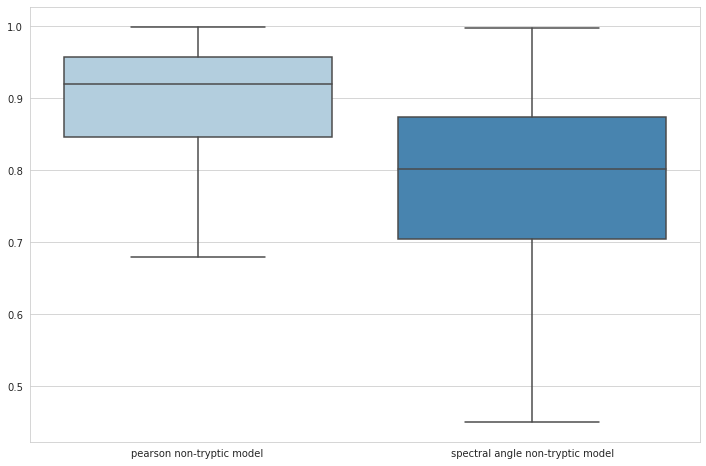

In [264]:
plt.figure(figsize=(12, 8))
model_perf = pd.DataFrame(columns=["pearson non-tryptic model", "spectral angle non-tryptic model"])
model_perf["pearson non-tryptic model"] = pear_corr
model_perf["spectral angle non-tryptic model"] = spec_corr
sns.set_style("whitegrid")
ax = sns.boxplot(data = model_perf, palette="Blues",showfliers = False)


plt.show()

# Performance eval of different in depth models 

In [265]:
tryptic_vectors, tryptic_targets, tryptic_psmids = load_data("data/tryptic_test_vector.pkl", "Y")
non_tryptic_vectors, non_tryptic_targets, non_tryptic_psmids = load_data("data/non_tryptic_test_vector.pkl", "Y")

In [266]:
tryptic_test = xgb.DMatrix(tryptic_vectors, label=tryptic_targets)
non_tryptic_test = xgb.DMatrix(non_tryptic_vectors, label=non_tryptic_targets)

In [267]:
predictions_tryptic = bst3.predict(tryptic_test)
predictions_non_tryptic = bst3.predict(non_tryptic_test)

In [268]:
New_model_perf.head()

,pearson correlation,spectral angle,type,Model
0,0.698893,0.696070,tryptic,new model
1,0.921131,0.762100,tryptic,new model
2,0.980401,0.867205,tryptic,new model
3,0.919154,0.856744,tryptic,new model
4,0.956148,0.800840,tryptic,new model


In [269]:
tryptic_test_LC = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
tryptic_new_model = Scorer(tryptic_psmids)
tryptic_test_LC["pearson correlation"], tryptic_test_LC["spectral angle"] = tryptic_new_model.psm_score(tryptic_targets,predictions_tryptic)
tryptic_test_LC["type"] = "tryptic"

non_tryptic_test_LC = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
non_tryptic_new_model = Scorer(non_tryptic_psmids)
non_tryptic_test_LC["pearson correlation"], non_tryptic_test_LC["spectral angle"] = non_tryptic_new_model.psm_score(non_tryptic_targets,predictions_non_tryptic)
non_tryptic_test_LC["type"] = "non-tryptic"

less_complex_model_perf = pd.concat([tryptic_test_LC, non_tryptic_test_LC])
less_complex_model_perf["Model"] = "Less complex model"

/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [270]:
model_comparison_complexity = pd.concat([New_model_perf,less_complex_model_perf ])

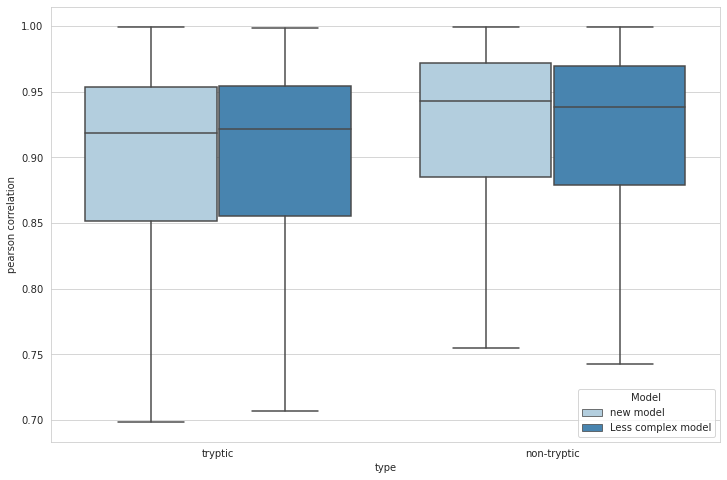

In [271]:
plt.figure(figsize=(12, 8))
sns.boxplot(data = model_comparison_complexity, x="type", y="pearson correlation",hue="Model", palette="Blues", showfliers = False)
plt.show()